In [ ]:
!pip install geopandas matplotlib pandas
!pip install rasterio
!pip install opencv-python pillow pandas
!pip install tensorflow tensorflow-gpu
!pip install -q -U keras-tuner

In [2]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors

sns.set_style("whitegrid", {"axes.grid": False})
import sklearn as sk
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import geopandas as gpd

from shapely.geometry import Point, Polygon

import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
import keras_tuner as kt

from PIL import Image
#import cv2
#import imghdr


from tensorflow.keras.optimizers import Adam

# Loading Data

In [3]:
survey_clusters = pd.read_csv("D:/Extended Research Project/survey_clusters_zaf.csv")
survey_household = pd.read_csv("D:/Extended Research Project/survey_household_zaf.csv")

night_lights_file = "D:/Extended Research Project/Google-Earth-Engine/SouthAfrica_Nightlights_2015-2017.tif"
elevation_file = "D:/Extended Research Project/Google-Earth-Engine/SouthAfrica_Elevation.tif"
temp_file = "D:/Extended Research Project/Google-Earth-Engine/SouthAfrica_Temperature_2016.tif"
shape_file= "D:/Extended Research Project/3. Project Kick Off (03_06_2024)/Survey Data/areas.geojson"
geojson_path = "D:/Extended Research Project/3. Project Kick Off (03_06_2024)/areas.geojson"

recode1 = pd.read_stata('D:/Extended Research Project/3. Project Kick Off (03_06_2024)/PCA/floor_recode.dta')
recode2 = pd.read_stata("D:/Extended Research Project/3. Project Kick Off (03_06_2024)/PCA/toilet_recode.dta")
recode3 = pd.read_stata("D:/Extended Research Project/3. Project Kick Off (03_06_2024)/PCA/water_recode.dta")



In [4]:
survey_household.shape

(11083, 30)

In [5]:
survey_household.isnull().sum()

survey_id         0
cluster_id        0
nhhmm             0
water             0
toilt             0
elec2             0
radio             0
tlvsn             0
rfrgr             0
bicyc             0
mtrcl             0
cartr             0
floor             0
nrmsl             0
lltel             0
shtlt           338
nptfl             0
mbtel             0
watch             0
adcrt             0
boats             0
cmptr             0
lndag         11083
lvstk             0
bkacc         11083
elec1             0
vcmcl             0
mrcwv             0
stove             0
wshmc             0
dtype: int64

In [6]:
print(recode1)

    floor_code  floor_qual
0           11         1.0
1           12         1.0
2           13         3.0
3           21         4.0
4           22         4.0
5           23         3.0
6           31         5.0
7           32         4.0
8           33         5.0
9           34         4.0
10          35         3.0
11          36         4.0
12          37         4.0
13          38         3.0
14          41         2.0
15          96         1.0
16          99         1.0
17          24         5.0


In [7]:
print(recode2)

    toilet_code  toilet_qual
0            11          5.0
1            12          5.0
2            13          4.0
3            14          5.0
4            15          5.0
5            21          4.0
6            22          3.0
7            23          2.0
8            24          3.0
9            25          2.0
10           26          2.0
11           31          1.0
12           32          1.0
13           41          4.0
14           42          2.0
15           43          3.0
16           44          4.0
17           51          1.0
18           71          1.0
19           91          4.0
20           92          2.0
21           96          1.0
22           99          1.0
23           30          1.0
24           16          4.0


In [8]:
print(recode3)

    water_code  water_qual
0           11         5.0
1           12         5.0
2           13         5.0
3           14         4.0
4           21         3.0
5           22         3.0
6           23         3.0
7           24         2.0
8           25         2.0
9           31         4.0
10          32         4.0
11          33         4.0
12          34         4.0
13          35         3.0
14          36         2.0
15          41         1.0
16          42         1.0
17          43         1.0
18          44         1.0
19          45         1.0
20          46         1.0
21          51         1.0
22          52         1.0
23          53         2.0
24          54         2.0
25          55         3.0
26          61         4.0
27          62         4.0
28          71         5.0
29          72         5.0
30          81         1.0
31          91         4.0
32          96         1.0
33          99         1.0
34          37         2.0
35          38         2.0
3

In [9]:
survey_household.describe()

cluster_id         nhhmm         water         toilt         elec2  \
count  11083.000000  11083.000000  11083.000000  11083.000000  11083.000000   
mean     372.411892      3.505369     16.399621     16.887034      0.899756   
std      217.246918      2.397331     12.939313      7.490152      0.300338   
min        1.000000      1.000000     11.000000     11.000000      0.000000   
25%      182.000000      2.000000     11.000000     11.000000      1.000000   
50%      369.000000      3.000000     12.000000     11.000000      1.000000   
75%      560.000000      5.000000     14.000000     23.000000      1.000000   
max      750.000000     24.000000     96.000000     96.000000      1.000000   

              radio         tlvsn         rfrgr         bicyc         mtrcl  \
count  11083.000000  11083.000000  11083.000000  11083.000000  11083.000000   
mean       0.604259      0.753767      0.744834      0.074889      0.020121   
std        0.489031      0.430835      0.435974      0.263225      0.140420   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      1.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      1.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...         boats         cmptr  lndag         lvstk  bkacc  \
count  ...  11083.000000  11083.000000    0.0  11083.000000    0.0   
mean   ...      0.005775      0.196427    NaN      0.177930    NaN   
std    ...      0.075775      0.397313    NaN      0.382471    NaN   
min    ...      0.000000      0.000000    NaN      0.000000    NaN   
25%    ...      0.000000      0.000000    NaN      0.000000    NaN   
50%    ...      0.000000      0.000000    NaN      0.000000    NaN   
75%    ...      0.000000      0.000000    NaN      0.000000    NaN   
max    ...      1.000000      1.000000    NaN      1.000000    NaN   

              elec1         vcmcl         mrcwv         stove         wshmc  
count  11083.000000  11083.000000  11083.000000  11083.000000  11083.000000  
mean       0.896959      0.121989      0.490481      0.832175      0.347559  
std        0.304026      0.327287      0.499932      0.373727      0.476217  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        1.000000      0.000000      0.000000      1.000000      0.000000  
50%        1.000000      0.000000      0.000000      1.000000      0.000000  
75%        1.000000      0.000000      1.000000      1.000000      1.000000  
max        1.000000      1.000000      1.000000      1.000000      1.000000  

[8 rows x 29 columns]

# Data Pre-Processing

In [10]:
s_household = survey_household.copy()

In [11]:
# Renaming variables
s_household = s_household.rename(columns={'water': 'water_code', 'toilt': 'toilet_code','floor': 'floor_code'})

In [12]:
# Adding new variable Number of bedrooms per person (rpper) + Fixing the Non-polluting fuel column (nptfl)
s_household['rpper'] = s_household['nrmsl'] / s_household['nhhmm']
s_household['nptfl'] = s_household['nptfl'].apply(lambda x: 1 if x in [1, 2, 3, 4, 12, 13, 14] else (0 if x in [5, 6, 7, 8, 9, 10, 11, 95, 96, 99] else x))

In [13]:
# Merging on recode data - Recode data for floor, toilet and water from Yeh et al. (2020) 
s_household = s_household.merge(recode1, on='floor_code', how='left')
s_household = s_household.merge(recode2, on='toilet_code', how='left')
s_household = s_household.merge(recode3, on='water_code', how='left')

In [14]:
s_household.describe()

cluster_id         nhhmm    water_code   toilet_code         elec2  \
count  11083.000000  11083.000000  11083.000000  11083.000000  11083.000000   
mean     372.411892      3.505369     16.399621     16.887034      0.899756   
std      217.246918      2.397331     12.939313      7.490152      0.300338   
min        1.000000      1.000000     11.000000     11.000000      0.000000   
25%      182.000000      2.000000     11.000000     11.000000      1.000000   
50%      369.000000      3.000000     12.000000     11.000000      1.000000   
75%      560.000000      5.000000     14.000000     23.000000      1.000000   
max      750.000000     24.000000     96.000000     96.000000      1.000000   

              radio         tlvsn         rfrgr         bicyc         mtrcl  \
count  11083.000000  11083.000000  11083.000000  11083.000000  11083.000000   
mean       0.604259      0.753767      0.744834      0.074889      0.020121   
std        0.489031      0.430835      0.435974      0.263225      0.140420   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      1.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      1.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...  bkacc         elec1         vcmcl         mrcwv         stove  \
count  ...    0.0  11083.000000  11083.000000  11083.000000  11083.000000   
mean   ...    NaN      0.896959      0.121989      0.490481      0.832175   
std    ...    NaN      0.304026      0.327287      0.499932      0.373727   
min    ...    NaN      0.000000      0.000000      0.000000      0.000000   
25%    ...    NaN      1.000000      0.000000      0.000000      1.000000   
50%    ...    NaN      1.000000      0.000000      0.000000      1.000000   
75%    ...    NaN      1.000000      0.000000      1.000000      1.000000   
max    ...    NaN      1.000000      1.000000      1.000000      1.000000   

              wshmc         rpper    floor_qual   toilet_qual    water_qual  
count  11083.000000  11083.000000  11083.000000  11083.000000  11083.000000  
mean       0.347559      0.876502      4.058919      3.889380      4.532166  
std        0.476217      0.694510      0.936190      1.366678      0.946817  
min        0.000000      0.071429      1.000000      1.000000      1.000000  
25%        0.000000      0.500000      4.000000      2.000000      4.000000  
50%        0.000000      0.666667      4.000000      5.000000      5.000000  
75%        1.000000      1.000000      5.000000      5.000000      5.000000  
max        1.000000     13.000000      5.000000      5.000000      5.000000  

[8 rows x 33 columns]

In [15]:
#Dropping the unnecessary features
s_household = s_household.drop(columns=['water_code', 'toilet_code', 'floor_code', 'bkacc', 'lndag'])

In [16]:
#Removing missing values
s_household = s_household.dropna()

In [17]:
s_household.isnull().sum()

survey_id      0
cluster_id     0
nhhmm          0
elec2          0
radio          0
tlvsn          0
rfrgr          0
bicyc          0
mtrcl          0
cartr          0
nrmsl          0
lltel          0
shtlt          0
nptfl          0
mbtel          0
watch          0
adcrt          0
boats          0
cmptr          0
lvstk          0
elec1          0
vcmcl          0
mrcwv          0
stove          0
wshmc          0
rpper          0
floor_qual     0
toilet_qual    0
water_qual     0
dtype: int64

# Segmenting Assets, Non-Assets, Yeh et al Variables and All

In [18]:
asset = s_household[['elec2', 'radio', 'tlvsn', 'rfrgr', 'bicyc', 'mtrcl', 'cartr', 'lltel', 'mbtel', 'watch',
                    'adcrt', 'boats', 'cmptr' , 'lvstk', 'elec1', 'vcmcl', 'mrcwv', 'stove', 'wshmc']].copy()
all_factors = s_household[[ 'elec2', 'radio', 'tlvsn', 'rfrgr',
       'bicyc', 'mtrcl', 'cartr',  'lltel', 'shtlt', 'nptfl', 'mbtel',
       'watch', 'adcrt', 'boats', 'cmptr', 'lvstk', 'rpper', 'floor_qual',
       'toilet_qual', 'water_qual', 'elec1' ,'vcmcl', 'mrcwv', 'stove', 'wshmc']].copy()
non_asset = s_household[[ 'floor_qual','toilet_qual', 'water_qual',  'shtlt', 'nptfl', 'rpper' ]].copy()
yeh = s_household[[ 'elec2', 'radio', 'tlvsn', 'rfrgr','mtrcl', 'cartr', 'rpper', 'floor_qual',
       'toilet_qual', 'water_qual', 'mbtel']].copy()

# Constructing the Wealth Index using PCA

Asset

In [19]:
scaler_asset = StandardScaler(with_std=True)

#fitting and transforming data
scaled_asset = scaler_asset.fit_transform(asset)

#checking mean to see if the values are close to 0
print(scaled_asset.mean(axis=0)[:10])
print("Standard deviation of each feature:", scaled_asset.std(axis=0)[:10])

[ 1.24320181e-16  2.51285472e-17  1.25642736e-17 -7.67081967e-17
  9.25788581e-17 -9.91916337e-18 -5.29022046e-17  1.85157716e-17
  1.89786659e-16  0.00000000e+00]
Standard deviation of each feature: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Explained Variance Ratio of Asset:  [0.25596454]


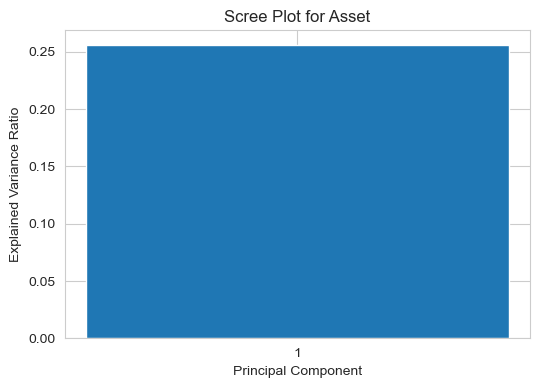

In [20]:
#Dimensionality Reduction
PCAthreshold = 1
pca_asset = PCA(n_components = PCAthreshold, svd_solver="full")
pca_asset_vals = pca_asset.fit_transform(scaled_asset)

explained_variance_ratio_asset = pca_asset.explained_variance_ratio_
print("Explained Variance Ratio of Asset: ", explained_variance_ratio_asset)

#plotting a scree plot
plt.figure(figsize=(6, 4))
#barplot with explained variance ratio
plt.bar(np.arange(1, len(explained_variance_ratio_asset) + 1), explained_variance_ratio_asset, align='center')
plt.title('Scree Plot for Asset')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio_asset) + 1))
plt.grid(True)
plt.show()

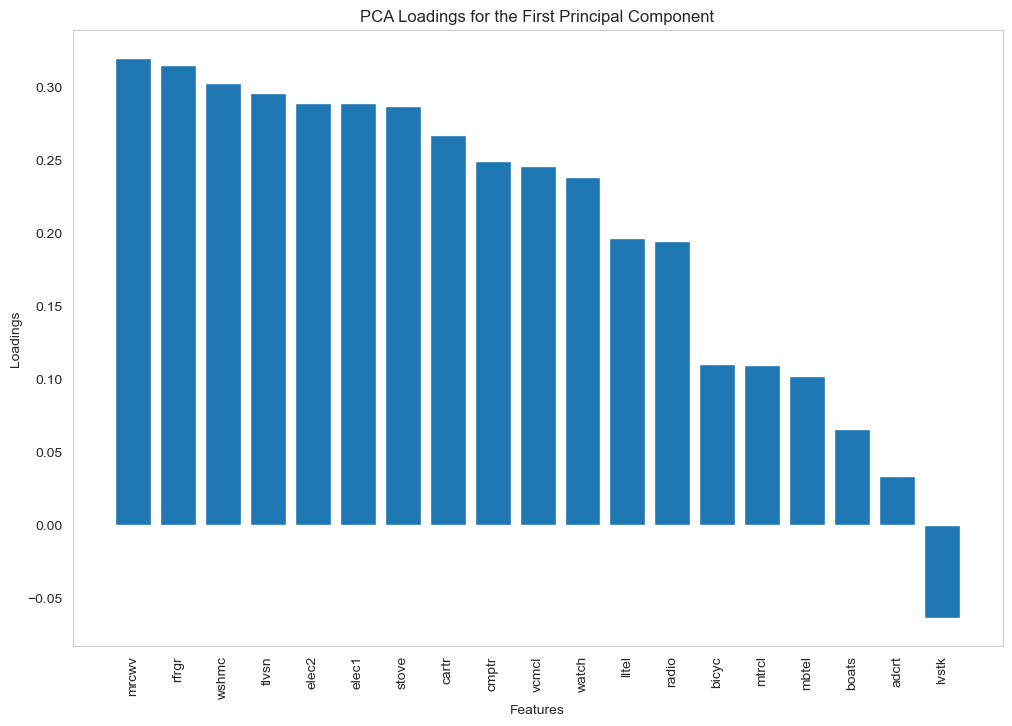

In [21]:
# Extract loadings for the first principal component
loadings_asset = pca_asset.components_[0]

# Assuming 'scaled_all' was created from a DataFrame 'all_factors'
# with the same column names
feature_names_asset = asset.columns

# Create a DataFrame for loadings
loadings_df_asset = pd.DataFrame(data=loadings_asset, index=feature_names_asset, columns=['loadings_asset'])
loadings_df_asset = loadings_df_asset.sort_values(by='loadings_asset', ascending=False)

# Plot the loadings
plt.figure(figsize=(12, 8))
plt.bar(loadings_df_asset.index, loadings_df_asset['loadings_asset'])
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.title('PCA Loadings for the First Principal Component')
plt.xticks(rotation=90)
plt.show()

Non-Asset

In [22]:
scaler_non_asset = StandardScaler(with_std=True)

#fitting and transforming data
scaled_non_asset = scaler_non_asset.fit_transform(non_asset)

#checking mean to see if the values are close to 0
print(scaled_non_asset.mean(axis=0)[:10])
print(scaled_non_asset.std(axis=0)[:10])

[ 3.76928208e-16  7.53856416e-17 -3.22703448e-16  6.34826455e-17
 -8.99337478e-17 -6.24907292e-17]
[1. 1. 1. 1. 1. 1.]


Explained Variance Ratio of Non-Asset:  [0.32679009]


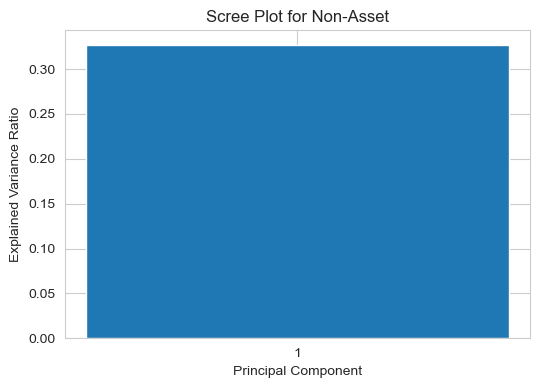

In [23]:
#Dimensionality Reduction
PCAthreshold = 1
pca_non_asset = PCA(n_components = PCAthreshold, svd_solver="full")
pca_non_asset_vals = pca_non_asset.fit_transform(scaled_non_asset)

explained_variance_ratio_non_asset = pca_non_asset.explained_variance_ratio_
print("Explained Variance Ratio of Non-Asset: ", explained_variance_ratio_non_asset)

#plotting a scree plot
plt.figure(figsize=(6, 4))
#barplot with explained variance ratio
plt.bar(np.arange(1, len(explained_variance_ratio_non_asset) + 1), explained_variance_ratio_non_asset, align='center')
plt.title('Scree Plot for Non-Asset')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio_non_asset) + 1))
plt.grid(True)
plt.show()

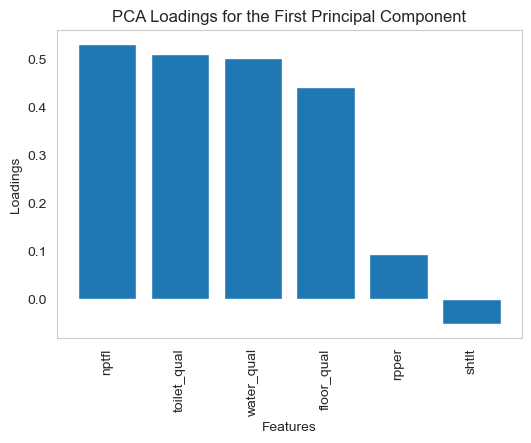

In [24]:
# Extract loadings for the first principal component
loadings_n_asset = pca_non_asset.components_[0]

# Assuming 'scaled_all' was created from a DataFrame 'all_factors'
# with the same column names
feature_names_n_asset = non_asset.columns

# Create a DataFrame for loadings
loadings_df_n_asset = pd.DataFrame(data=loadings_n_asset, index=feature_names_n_asset, columns=['loadings_n_asset'])
loadings_df_n_asset  = loadings_df_n_asset .sort_values(by='loadings_n_asset', ascending=False)

# Plot the loadings
plt.figure(figsize=(6, 4))
plt.bar(loadings_df_n_asset.index, loadings_df_n_asset['loadings_n_asset'])
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.title('PCA Loadings for the First Principal Component')
plt.xticks(rotation=90)
plt.show()

Yeh

In [25]:
scaler_yeh = StandardScaler(with_std=True)

#fitting and transforming data
scaled_yeh = scaler_yeh.fit_transform(yeh)

#checking mean to see if the values are close to 0
print(scaled_yeh.mean(axis=0)[:10])
print(scaled_yeh.std(axis=0)[:10])

[ 1.24320181e-16  2.51285472e-17  1.25642736e-17 -7.67081967e-17
 -9.91916337e-18 -5.29022046e-17 -6.24907292e-17  3.76928208e-16
  7.53856416e-17 -3.22703448e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [26]:
#Dimensionality Reduction
PCAthreshold = 1
pca_yeh = PCA(n_components = PCAthreshold, svd_solver="full")
pca_yeh_vals = pca_yeh.fit_transform(scaled_yeh)

Explained Variance Ratio of Yeh Variables:  [0.27071235]


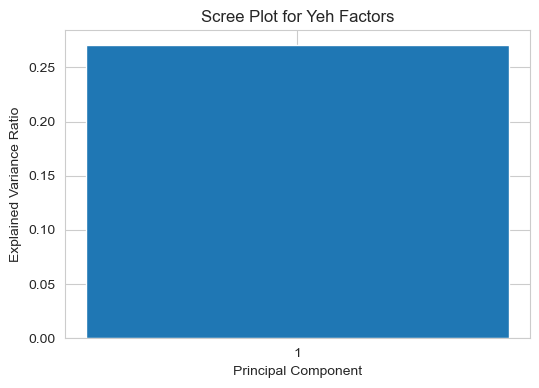

In [27]:
explained_variance_ratio_yeh = pca_yeh.explained_variance_ratio_
print("Explained Variance Ratio of Yeh Variables: ", explained_variance_ratio_yeh)

#plotting a scree plot
plt.figure(figsize=(6, 4))
#barplot with explained variance ratio
plt.bar(np.arange(1, len(explained_variance_ratio_yeh) + 1), explained_variance_ratio_yeh, align='center')
plt.title('Scree Plot for Yeh Factors')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio_yeh) + 1))
plt.grid(True)
plt.show()

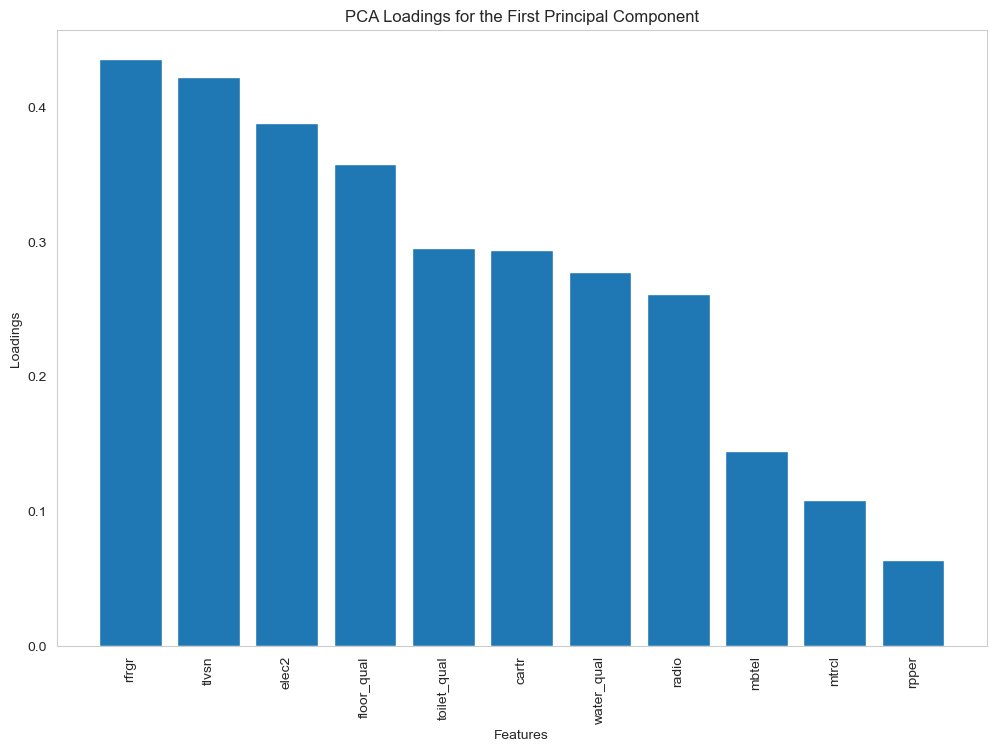

In [28]:
# Extract loadings for the first principal component
loadings_yeh = pca_yeh.components_[0]

# Assuming 'scaled_all' was created from a DataFrame 'all_factors'
# with the same column names
feature_names_yeh = yeh.columns

# Create a DataFrame for loadings
loadings_df_yeh = pd.DataFrame(data=loadings_yeh, index=feature_names_yeh, columns=['loadings_yeh'])
loadings_df_yeh  = loadings_df_yeh.sort_values(by='loadings_yeh', ascending=False)

# Plot the loadings
plt.figure(figsize=(12, 8))
plt.bar(loadings_df_yeh.index, loadings_df_yeh['loadings_yeh'])
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.title('PCA Loadings for the First Principal Component')
plt.xticks(rotation=90)
plt.show()

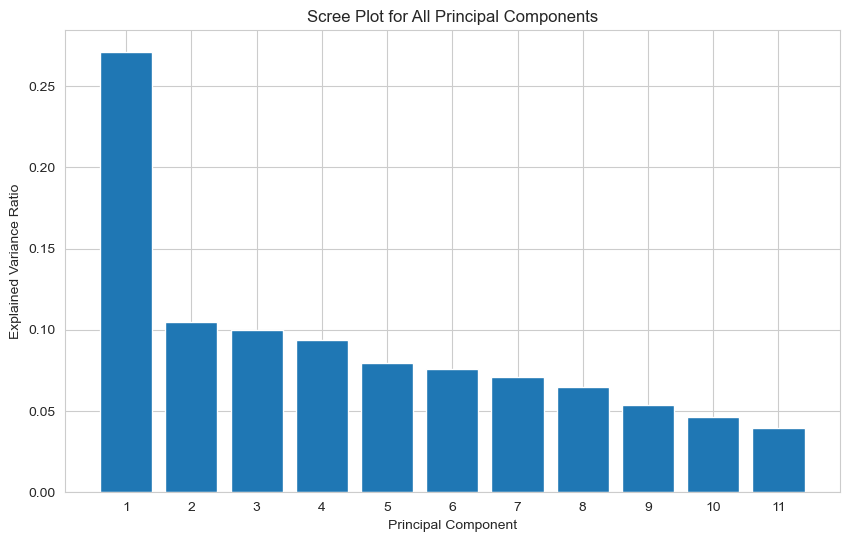

In [29]:
# Assuming your data is stored in 'scaled_all'
pca_yeh_all_components = PCA()  # This will compute all components
pca_yeh_all_components.fit(scaled_yeh)

# Getting explained variance ratio
explained_variance_ratio_yeh_all_components = pca_yeh_all_components.explained_variance_ratio_

# Getting all PCA components
components_yeh_all_components = pca_yeh_all_components.components_

# Plotting the Scree plot
plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility
# Bar plot with explained variance ratio for all components
plt.bar(np.arange(1, len(explained_variance_ratio_yeh_all_components) + 1), explained_variance_ratio_yeh_all_components, align='center')
plt.title('Scree Plot for All Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio_yeh_all_components) + 1))  # Show all component numbers
plt.grid(True)
plt.show()

All factors

In [30]:
scaler_all = StandardScaler(with_std=True)

#fitting and transforming data
scaled_all = scaler_all.fit_transform(all_factors)

#checking mean to see if the values are close to 0
print(scaled_all.mean(axis=0)[:10])
print(scaled_all.std(axis=0)[:10])

[ 1.24320181e-16  2.51285472e-17  1.25642736e-17 -7.67081967e-17
  9.25788581e-17 -9.91916337e-18 -5.29022046e-17  1.85157716e-17
  6.34826455e-17 -8.99337478e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [31]:
#Dimensionality Reduction
PCAthreshold = 1
pca_all = PCA(n_components = PCAthreshold, svd_solver="full")
pca_all_vals = pca_all.fit_transform(scaled_all)

Explained Variance Ratio of All Variables:  [0.23695839]


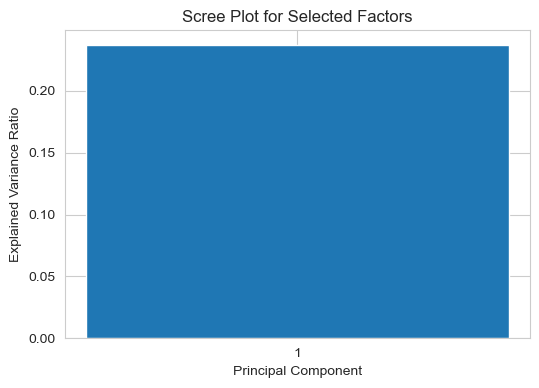

In [32]:
explained_variance_ratio_all = pca_all.explained_variance_ratio_
print("Explained Variance Ratio of All Variables: ", explained_variance_ratio_all)
#plotting a scree plot
plt.figure(figsize=(6, 4))
#barplot with explained variance ratio
plt.bar(np.arange(1, len(explained_variance_ratio_all) + 1), explained_variance_ratio_all, align='center')
plt.title('Scree Plot for Selected Factors')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio_all) + 1))
plt.grid(True)
plt.show()

In [33]:

# Dictionary mapping old column names to new descriptive names
column_rename_mapping = {
    'elec2': "Has electricity",
    'radio': "Has radio",
    'tlvsn': "Has television",
    'rfrgr': "Has refrigerator",
    'bicyc': "Has bicycle",
    'mtrcl': "Has motorcycle",
    'cartr': "Has car/truck",
    'lltel': "Has landline",
    'shtlt': "Shared toilet",
    'nptfl': "Fuel type",
    'mbtel': "Has mobile phone",
    'watch': "Has watch",
    'adcrt': "Animal drawn carts",
    'boats': "Has boats",
    'cmptr': "Has computer",
    'lvstk': "Has livestock",
    'rpper': "Roof quality",
    'floor_qual': "Floor quality",
    'toilet_qual': "Toilet quality",
    'water_qual': "Water quality",
    'elec1': "Electricity connected to mains",
    'vcmcl': "Vacuum cleaner/floor polisher",
    'mrcwv': "Has microwave",
    'stove': "Has stove",
    'wshmc': "Has washing machine"
}

# Apply the renaming to the DataFrame
all_factors = all_factors.rename(columns=column_rename_mapping)


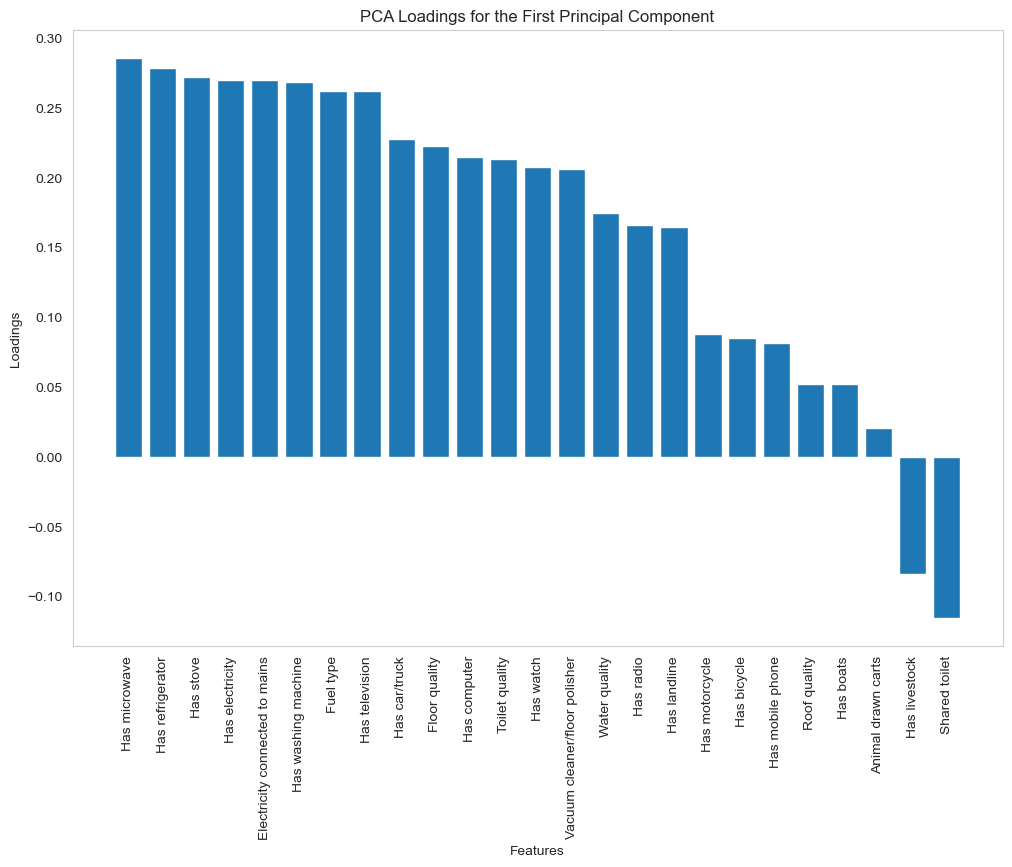

In [34]:
# Assuming 'pca_all' and 'all_factors' are already defined
# Extract loadings for the first principal component
loadings = pca_all.components_[0]

# Assuming 'scaled_all' was created from a DataFrame 'all_factors'
# with the same column names
feature_names = all_factors.columns

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(data=loadings, index=feature_names, columns=['Loading'])
loadings_df = loadings_df.sort_values(by='Loading', ascending=False)

# Plot the loadings
plt.figure(figsize=(12, 8))
plt.bar(loadings_df.index, loadings_df['Loading'])
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.title('PCA Loadings for the First Principal Component')
plt.xticks(rotation=90)
plt.show()

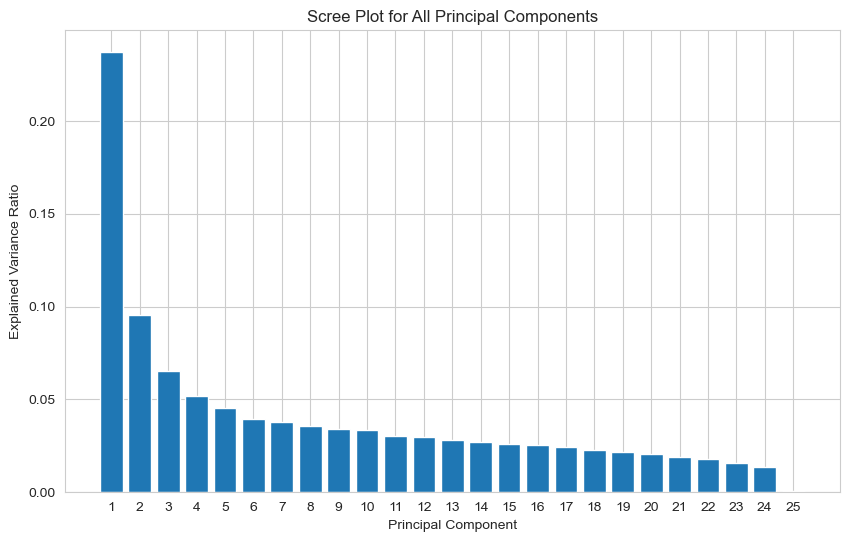

In [35]:
# Assuming your data is stored in 'data'
pca_all = PCA()  # This will compute all components
pca_all.fit(scaled_all)

# Getting explained variance ratio
explained_variance_ratio_all_components = pca_all.explained_variance_ratio_

# Getting all PCA components
pca_all_components = pca_all.components_

plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility
# Bar plot with explained variance ratio for all components
plt.bar(np.arange(1, len(explained_variance_ratio_all_components) + 1), explained_variance_ratio_all_components, align='center')
plt.title('Scree Plot for All Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio_all_components) + 1))  # Show all component numbers
plt.grid(True)
plt.show()

# Creating Dataframes with survey ids, cluster ids and 1st component of pca

In [36]:
ids = s_household[['survey_id', 'cluster_id']]

In [37]:
pca_df_asset = pd.DataFrame(data=pca_asset_vals, columns=['Wealth Index'])
asset_df = pd.concat([ids, pca_df_asset], axis=1)
asset_df = asset_df.dropna()
print(asset_df)

        survey_id  cluster_id  Wealth Index
0      ZAF2016DHS         1.0      0.138475
1      ZAF2016DHS         1.0     -1.834704
2      ZAF2016DHS         1.0     -0.567282
3      ZAF2016DHS         1.0      1.971845
4      ZAF2016DHS         1.0      3.310460
...           ...         ...           ...
10740  ZAF2016DHS       728.0      1.937742
10741  ZAF2016DHS       728.0     -1.266834
10742  ZAF2016DHS       728.0     -0.159787
10743  ZAF2016DHS       728.0     -0.395332
10744  ZAF2016DHS       728.0      0.703190

[10420 rows x 3 columns]


In [38]:
pca_df_non_asset = pd.DataFrame(data=pca_non_asset_vals, columns=['Wealth Index'])
# Concatenate the ids and the PCA DataFrame
non_asset_df = pd.concat([ids, pca_df_non_asset], axis=1)
# Drop any remaining NA values
non_asset_df = non_asset_df.dropna()

In [39]:
pca_df_yeh = pd.DataFrame(data=pca_yeh_vals, columns=['Wealth Index'])
#pca_df_yeh['Wealth Index'] *= 1
yeh_df = pd.concat([ids, pca_df_yeh], axis=1)
yeh_df = yeh_df.dropna()


In [40]:
pca_df_all = pd.DataFrame(data=pca_all_vals, columns=['Wealth Index'])
#pca_df_all['Wealth Index'] *= 1
all_df = pd.concat([ids, pca_df_all], axis=1)
all_df = all_df.dropna()

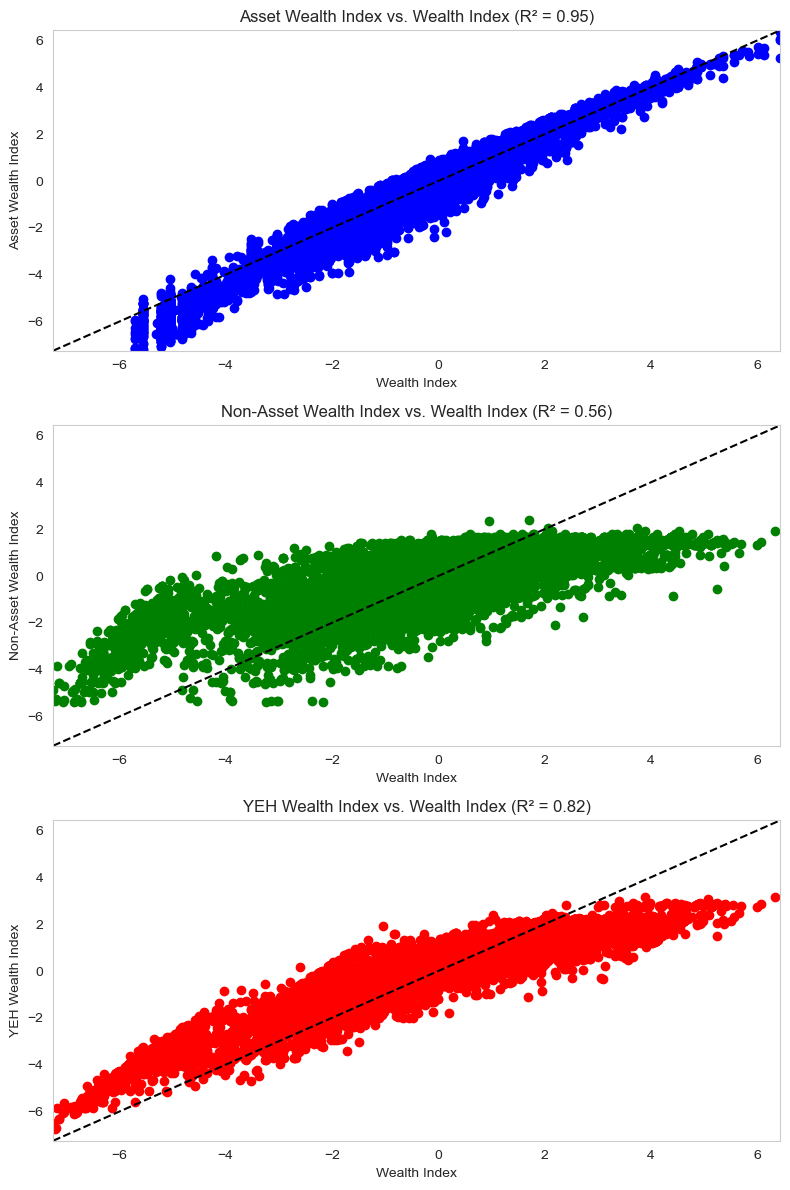

In [41]:
# subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

#Wealth Index using all assets and non-assets variables
x = all_df['Wealth Index']
y1 = asset_df['Wealth Index']
r2_1 = r2_score(x, y1)
axs[0].scatter(y1, x, color='blue')
axs[0].set_title(f'Asset Wealth Index vs. Wealth Index (R² = {r2_1:.2f})')
axs[0].set_xlabel('Wealth Index')
axs[0].set_ylabel('Asset Wealth Index')

# Wealth index using only non-asset variables
y2 = non_asset_df['Wealth Index']
r2_2 = r2_score(x, y2)
axs[1].scatter(x, y2, color='green')
axs[1].set_title(f'Non-Asset Wealth Index vs. Wealth Index (R² = {r2_2:.2f})')
axs[1].set_xlabel('Wealth Index')
axs[1].set_ylabel('Non-Asset Wealth Index')

# Wealth Index using yeh varibles
y3 = yeh_df['Wealth Index']
r2_3 = r2_score(x, y3)
axs[2].scatter(x, y3, color='red')
axs[2].set_title(f'YEH Wealth Index vs. Wealth Index (R² = {r2_3:.2f})')
axs[2].set_xlabel('Wealth Index')
axs[2].set_ylabel('YEH Wealth Index')

#To create similar axes for all 3 graphs
min_val = min(x.min(), y1.min(), y2.min(), y3.min())
max_val = max(x.max(), y1.max(), y2.max(), y3.max())

for ax in axs:
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    # Add y = x line
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')

plt.tight_layout()
plt.show()

# Merging survey_clusters with the wealth indexes for spatial analysis

All factors

In [42]:
merged_all_df = pd.merge(all_df, survey_clusters, on=['survey_id', 'cluster_id'], how='left')

Asset Factors

In [43]:
merged_asset_df = pd.merge(asset_df, survey_clusters, on=['survey_id', 'cluster_id'], how='left')

Yeh Factors

In [44]:
merged_yeh_df = pd.merge(yeh_df, survey_clusters, on=['survey_id', 'cluster_id'], how='left')

Non-Asset

In [45]:
merged_non_asset_df = pd.merge(non_asset_df, survey_clusters, on=['survey_id', 'cluster_id'], how='left')

# Adding All the wealth indexes in 1 dataframe

In [46]:
merged_all_df['wi_yeh'] = merged_yeh_df['Wealth Index']
merged_all_df['wi_asset'] = merged_asset_df['Wealth Index']
merged_all_df['wi_non_asset'] = merged_non_asset_df['Wealth Index']

# Extracting Values from the Raster Files at the Cluster Locations

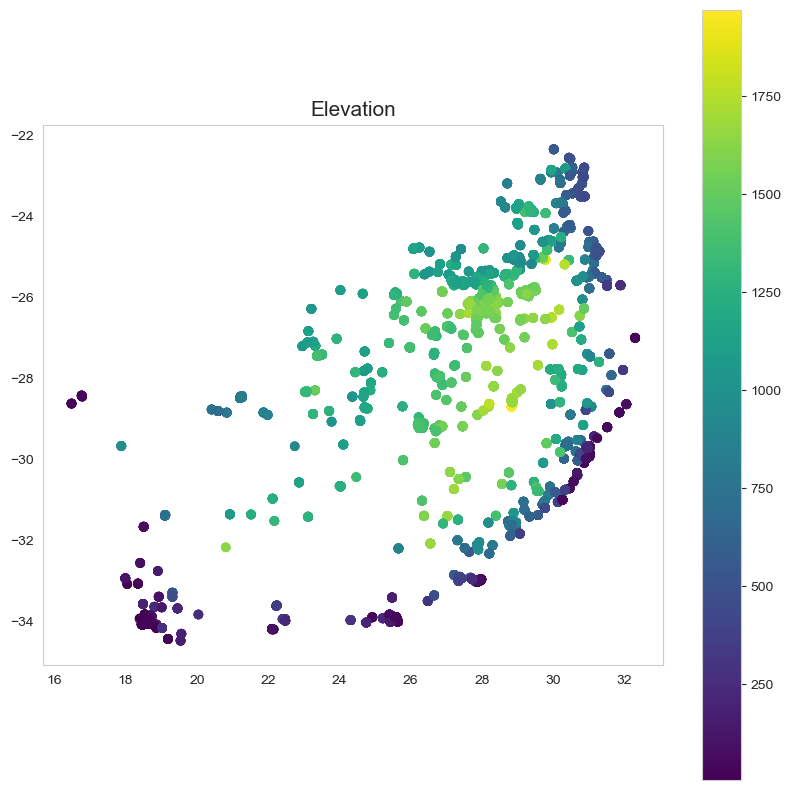

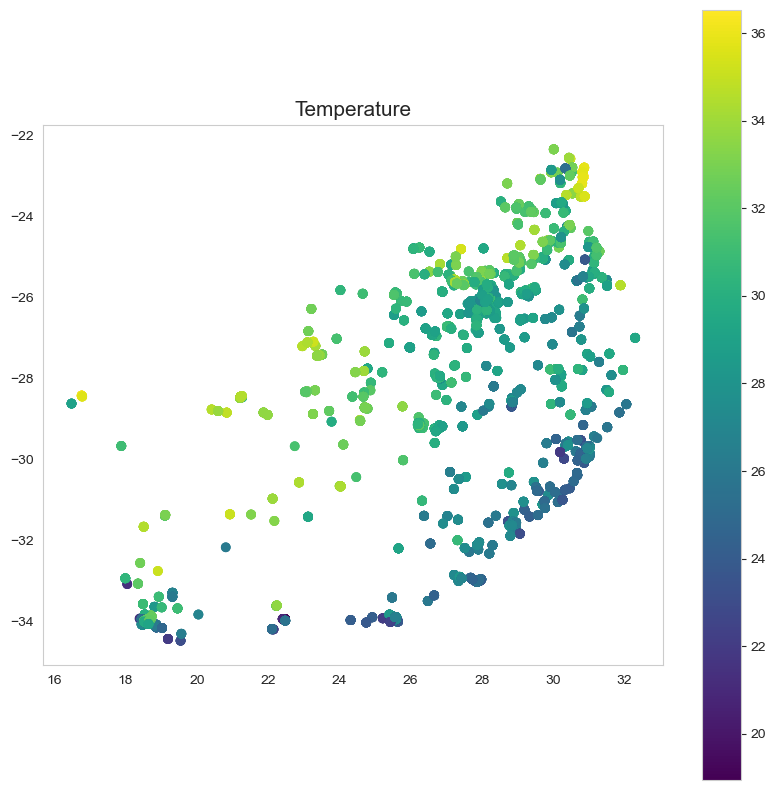

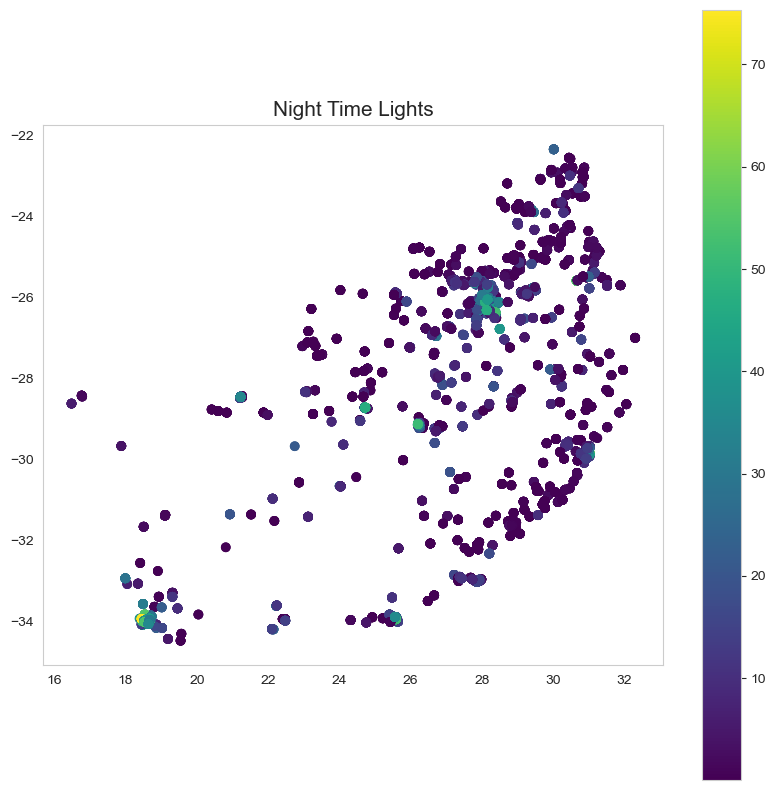

In [47]:
# Creation of a GeoDataFrame
all_clusters_gdf = gpd.GeoDataFrame(merged_all_df, geometry=gpd.points_from_xy(merged_all_df['longitude'], merged_all_df['latitude']))
all_clusters_gdf = all_clusters_gdf.set_crs(epsg=4326)

# Reading elevation data
elev = rasterio.open(elevation_file)

#Consistent CRS system
all_clusters_gdf = all_clusters_gdf.to_crs(elev.crs)

# Extract elevation values at the cluster points
elevation_values = []
for geom in all_clusters_gdf.geometry:
    coords = [(geom.x, geom.y)]
    for val in elev.sample(coords):
        elevation_values.append(val[0])

all_clusters_gdf['elevation'] = elevation_values


# Reading temperature data
temp = rasterio.open(temp_file)

# Consistent CRS system
all_clusters_gdf = all_clusters_gdf.to_crs(temp.crs)

# Extract temperature values at the cluster points
temperature_values = []
for geom in all_clusters_gdf.geometry:
    coords = [(geom.x, geom.y)]
    for val in temp.sample(coords):
        temperature_values.append(val[0])

all_clusters_gdf['temperature'] = temperature_values


# Read night lights data
night_lights = rasterio.open(night_lights_file)

# Convert cluster coordinates to the same CRS as the night lights raster
all_clusters_gdf = all_clusters_gdf.to_crs(night_lights.crs)

# Extract night lights values at the cluster points
night_lights_values = []
for geom in all_clusters_gdf.geometry:
    coords = [(geom.x, geom.y)]
    for val in night_lights.sample(coords):
        night_lights_values.append(val[0])

all_clusters_gdf['night_lights'] = night_lights_values


# Plotting the clusters with elevation values
fig, ax = plt.subplots(figsize=(10, 10))
all_clusters_gdf.plot(ax=ax, column='elevation', legend=True, cmap='viridis')
ax.set_title('Elevation', fontsize=15)
plt.show()

# Plotting the clusters with temperature values
fig, ax = plt.subplots(figsize=(10, 10))
all_clusters_gdf.plot(ax=ax, column='temperature', legend=True, cmap='viridis')
ax.set_title('Temperature', fontsize=15)
plt.show()

# Plotting the clusters with night lights values
fig, ax = plt.subplots(figsize=(10, 10))
all_clusters_gdf.plot(ax=ax, column='night_lights', legend=True, cmap='viridis')
ax.set_title('Night Time Lights', fontsize=15)
plt.show()


In [48]:
all_clusters_gdf.isnull().sum()

survey_id           0
cluster_id          0
Wealth Index        0
res_type            0
survey_region_id    0
longitude           0
latitude            0
geoloc_area_id      0
geoloc_distance     0
wi_yeh              0
wi_asset            0
wi_non_asset        0
geometry            0
elevation           0
temperature         3
night_lights        0
dtype: int64

In [49]:
all_clusters_gdf = all_clusters_gdf.dropna()

# Scaling the Features for KNN

In [50]:
features_to_scale = ['elevation', 'temperature', 'night_lights']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
scaled_features = scaler.fit_transform(all_clusters_gdf[features_to_scale])

# Create a DataFrame from the scaled features
scaled_features_df = pd.DataFrame(scaled_features, columns=[f'scaled_{feature}' for feature in features_to_scale])

# Concatenate the scaled features back to the original GeoDataFrame
all_clusters_gdf = pd.concat([all_clusters_gdf.reset_index(drop=True), scaled_features_df], axis=1)

# Print the resulting GeoDataFrame with scaled values
print(all_clusters_gdf)

        survey_id  cluster_id  Wealth Index res_type  survey_region_id  \
0      ZAF2016DHS         1.0      0.211578    urban                 7   
1      ZAF2016DHS         1.0     -1.474988    urban                 7   
2      ZAF2016DHS         1.0     -0.387927    urban                 7   
3      ZAF2016DHS         1.0      2.108944    urban                 7   
4      ZAF2016DHS         1.0      3.549685    urban                 7   
...           ...         ...           ...      ...               ...   
10412  ZAF2016DHS       728.0      2.051113    urban                 6   
10413  ZAF2016DHS       728.0     -1.750339    urban                 6   
10414  ZAF2016DHS       728.0      0.287492    urban                 6   
10415  ZAF2016DHS       728.0     -1.125474    urban                 6   
10416  ZAF2016DHS       728.0      0.540534    urban                 6   

       longitude   latitude geoloc_area_id  geoloc_distance    wi_yeh  \
0      27.387368 -26.400954    ZAF_4_G

In [51]:
all_clusters_gdf.isnull().sum()

survey_id              0
cluster_id             0
Wealth Index           0
res_type               0
survey_region_id       0
longitude              0
latitude               0
geoloc_area_id         0
geoloc_distance        0
wi_yeh                 0
wi_asset               0
wi_non_asset           0
geometry               0
elevation              0
temperature            0
night_lights           0
scaled_elevation       0
scaled_temperature     0
scaled_night_lights    0
dtype: int64

# Visualising the Raster Files with South Africa's Shapefile

C:\Users\Raisina Chowdhury\AppData\Local\Temp\ipykernel_23360\417709917.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  outer_boundary = [outer_boundary.geometry.unary_union]


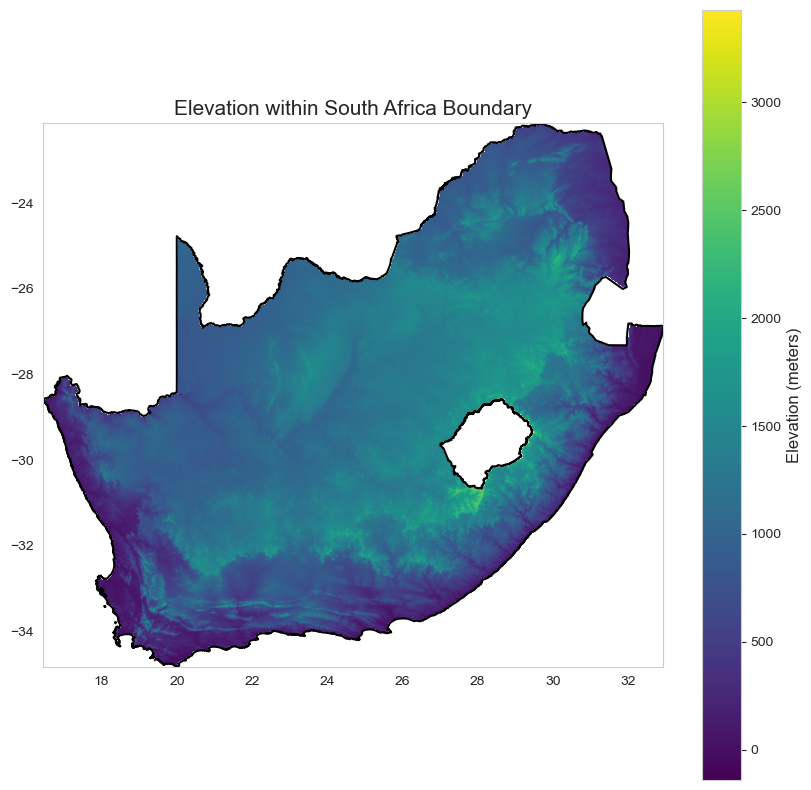

In [55]:
# Loading shapefile for South Africa
sa_boundary = gpd.read_file(shape_file)

# Removing inner boundaries of the shapefile
outer_boundary = sa_boundary.dissolve()

#forming an unified boundary
outer_boundary = [outer_boundary.geometry.unary_union]

#Cropping function to crop the raster data to fit in the SA shapefile
def crop_raster_with_boundary(raster_path, boundary):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, boundary, crop=True, nodata=-9999)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": -9999  # Use an integer nodata value
        })
    return out_image, out_meta

# Cropping
elev_cropped, elev_meta = crop_raster_with_boundary(elevation_file, outer_boundary)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

#Masking the data outside the boundary to 0
elev_cropped_masked = np.ma.masked_where(elev_cropped[0] == -9999, elev_cropped[0])

# Use 'viridis' colormap and set out-of-boundary data to white
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Plotting the cropped and masked elevation raster, extent = mapping the pixel co-ordinate to lat and long values using affine transformation in the meta data
cax = ax.imshow(elev_cropped_masked, cmap=cmap, extent=(elev_meta['transform'][2], 
                                                        elev_meta['transform'][2] + elev_meta['transform'][0] * elev_cropped.shape[2],
                                                        elev_meta['transform'][5] + elev_meta['transform'][4] * elev_cropped.shape[1], 
                                                        elev_meta['transform'][5]))

# Adding a color bar to indicate elevation values
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('Elevation (meters)', fontsize=12)

# Overlaying the South Africa boundary
outer_boundary_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(outer_boundary), crs=sa_boundary.crs)
outer_boundary_gdf.boundary.plot(ax=ax, edgecolor='black')

ax.set_title('Elevation within South Africa Boundary', fontsize=15)
plt.show()


C:\Users\Raisina Chowdhury\AppData\Local\Temp\ipykernel_23360\495567131.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  outer_boundary = [outer_boundary.geometry.unary_union]


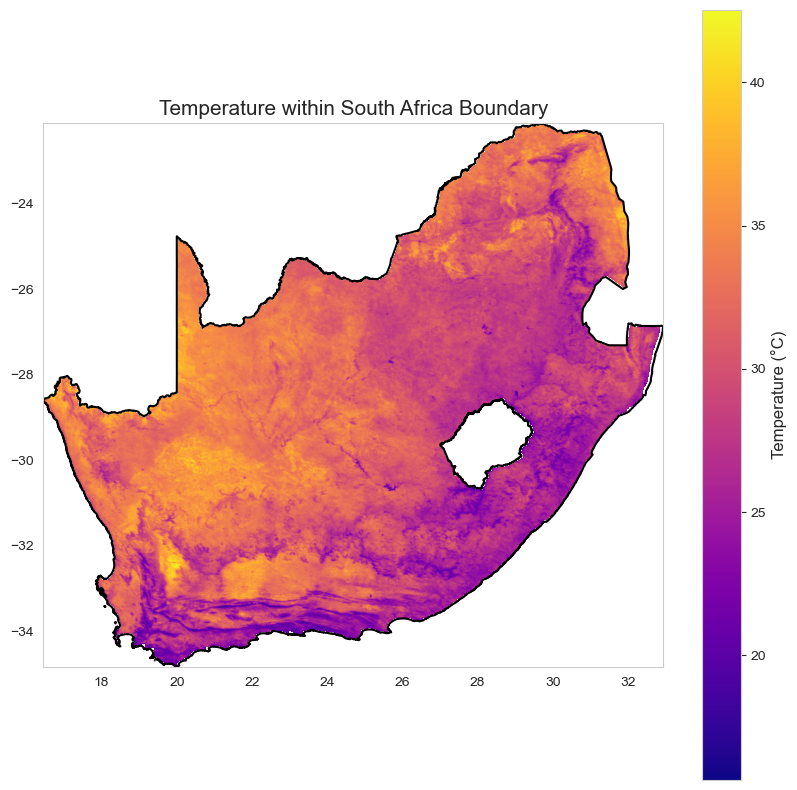

In [56]:
# Loading shapefile for South Africa
sa_boundary = gpd.read_file(shape_file)

# Removing inner boundaries of the shapefile
outer_boundary = sa_boundary.dissolve()

#forming an unified boundary
outer_boundary = [outer_boundary.geometry.unary_union]

#Cropping function to crop the raster data to fit in the SA shapefile
def crop_raster_with_boundary(raster_path, boundary, nodata_value=np.nan):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, boundary, crop=True, nodata=nodata_value)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "dtype": 'float64',  
            "nodata": nodata_value  # Use NaN as the nodata value
        })
    return out_image, out_meta

# Cropping
temperature_cropped, temperature_meta = crop_raster_with_boundary(temp_file, outer_boundary)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

#Masking the data outside the boundary 
temperature_cropped_masked = np.ma.masked_where(np.isnan(temperature_cropped[0]), temperature_cropped[0])

# Using a colourmap 'plasma' and set masked areas to white
cmap = plt.cm.plasma  
cmap.set_bad(color='white')

# Plotting, extent = mapping the pixel co-ordinate to lat and long values using affine transformation in the meta data
cax = ax.imshow(temperature_cropped_masked, cmap=cmap, extent=(temperature_meta['transform'][2], 
                                                               temperature_meta['transform'][2] + temperature_meta['transform'][0] * temperature_cropped.shape[2],
                                                               temperature_meta['transform'][5] + temperature_meta['transform'][4] * temperature_cropped.shape[1], 
                                                               temperature_meta['transform'][5]))

# color bar to indicate temperature values
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('Temperature (°C)', fontsize=12)

# Overlay the South Africa boundary
outer_boundary_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(outer_boundary), crs=sa_boundary.crs)
outer_boundary_gdf.boundary.plot(ax=ax, edgecolor='black')

ax.set_title('Temperature within South Africa Boundary', fontsize=15)
plt.show()


C:\Users\Raisina Chowdhury\AppData\Local\Temp\ipykernel_23360\3219034922.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  outer_boundary = [outer_boundary.geometry.unary_union]


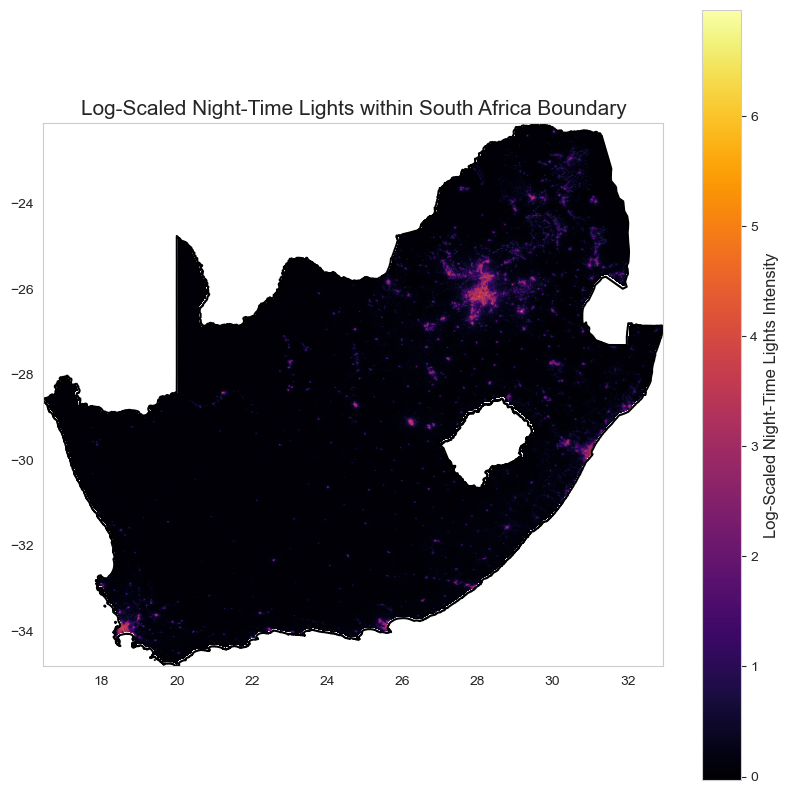

In [57]:
# Loading raster file
nightlights_raster_path = "D:/Extended Research Project/Google-Earth-Engine/SouthAfrica_Nightlights_2015-2017.tif"

# Loading Shapefile
sa_boundary = gpd.read_file(shape_file)

# Removing Inner Boundaries
outer_boundary = sa_boundary.dissolve()

#Masking prep
outer_boundary = [outer_boundary.geometry.unary_union]

# Cropping Function
def crop_and_mask_raster(raster_path, boundary, nodata_value=np.nan):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, boundary, crop=True, nodata=nodata_value)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "dtype": 'float32',  # Ensure the dtype is float32
            "nodata": nodata_value  # Use NaN as the nodata value
        })
    return out_image, out_meta

# Cropping and masking the night-time lights raster with the South Africa boundary
nightlights_cropped, nightlights_meta = crop_and_mask_raster(nightlights_raster_path, outer_boundary)

# Applying logarithmic transformation to enhance visibility
nightlights_cropped_log = np.log1p(nightlights_cropped[0])  # log1p to avoid log(0)

# Masking the data outside the boundary by setting it to NaN and display it as white
nightlights_cropped_log_masked = np.ma.masked_where(np.isnan(nightlights_cropped_log), nightlights_cropped_log)

# Using a colormap (e.g., 'inferno') and set 'bad' data (masked areas) to white
cmap = plt.cm.inferno  # Use a perceptually uniform color map
cmap.set_bad(color='white')

# Plotting the masked and log-transformed night-time lights raster, extent = mapping the pixel co-ordinate to lat and long values using affine transformation in the meta data
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(nightlights_cropped_log_masked, cmap=cmap, extent=(nightlights_meta['transform'][2], 
                                                                   nightlights_meta['transform'][2] + nightlights_meta['transform'][0] * nightlights_cropped.shape[2],
                                                                   nightlights_meta['transform'][5] + nightlights_meta['transform'][4] * nightlights_cropped.shape[1], 
                                                                   nightlights_meta['transform'][5]))

# Adding a color bar to indicate night-time lights intensity values in log scale
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('Log-Scaled Night-Time Lights Intensity', fontsize=12)

# Overlaying the South Africa boundary
outer_boundary_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(outer_boundary), crs=sa_boundary.crs)
outer_boundary_gdf.boundary.plot(ax=ax, edgecolor='black')

ax.set_title('Log-Scaled Night-Time Lights within South Africa Boundary', fontsize=15)
plt.show()



# EDA

Counts of Wealth Index ranges:
{'Above 2': 2076, 'Between 2 and -2': 6543, 'Below -2': 1798}


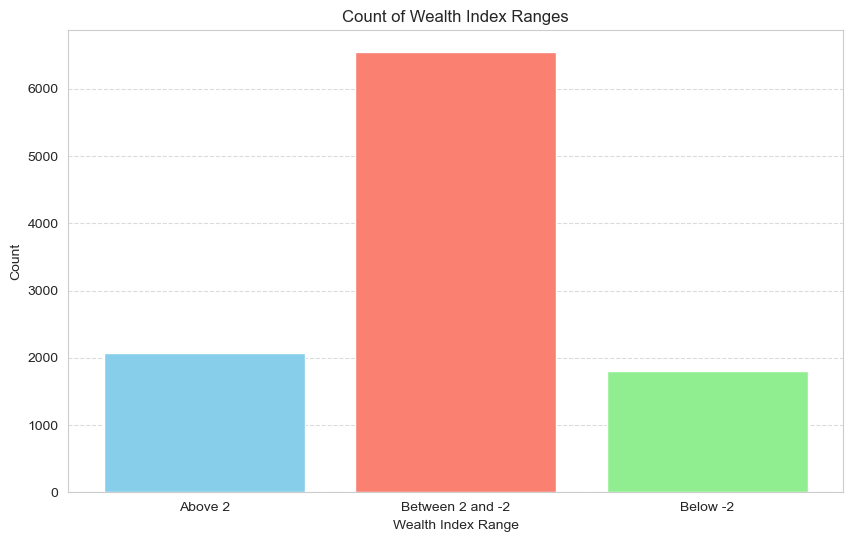

In [59]:
above_2 = all_clusters_gdf[all_clusters_gdf['Wealth Index'] > 2]
between_2_and_minus_2 = all_clusters_gdf[(all_clusters_gdf['Wealth Index'] <= 2) & (all_clusters_gdf['Wealth Index'] >= -2)]
below_minus_2 = all_clusters_gdf[all_clusters_gdf['Wealth Index'] < -2]

# Counting the instances in each group
counts = {
    'Above 2': above_2.shape[0],
    'Between 2 and -2': between_2_and_minus_2.shape[0],
    'Below -2': below_minus_2.shape[0]
}

print("Counts of Wealth Index ranges:")
print(counts)

# Plotting the counts
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Count of Wealth Index Ranges')
plt.xlabel('Wealth Index Range')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()

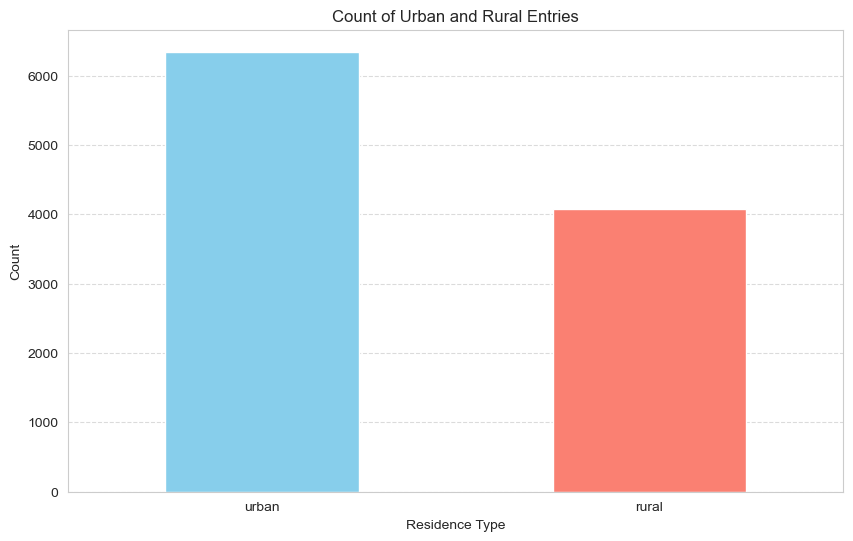

In [60]:
res_type_counts = all_clusters_gdf['res_type'].value_counts()

# Plotting the counts
plt.figure(figsize=(10, 6))
res_type_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Urban and Rural Entries')
plt.xlabel('Residence Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

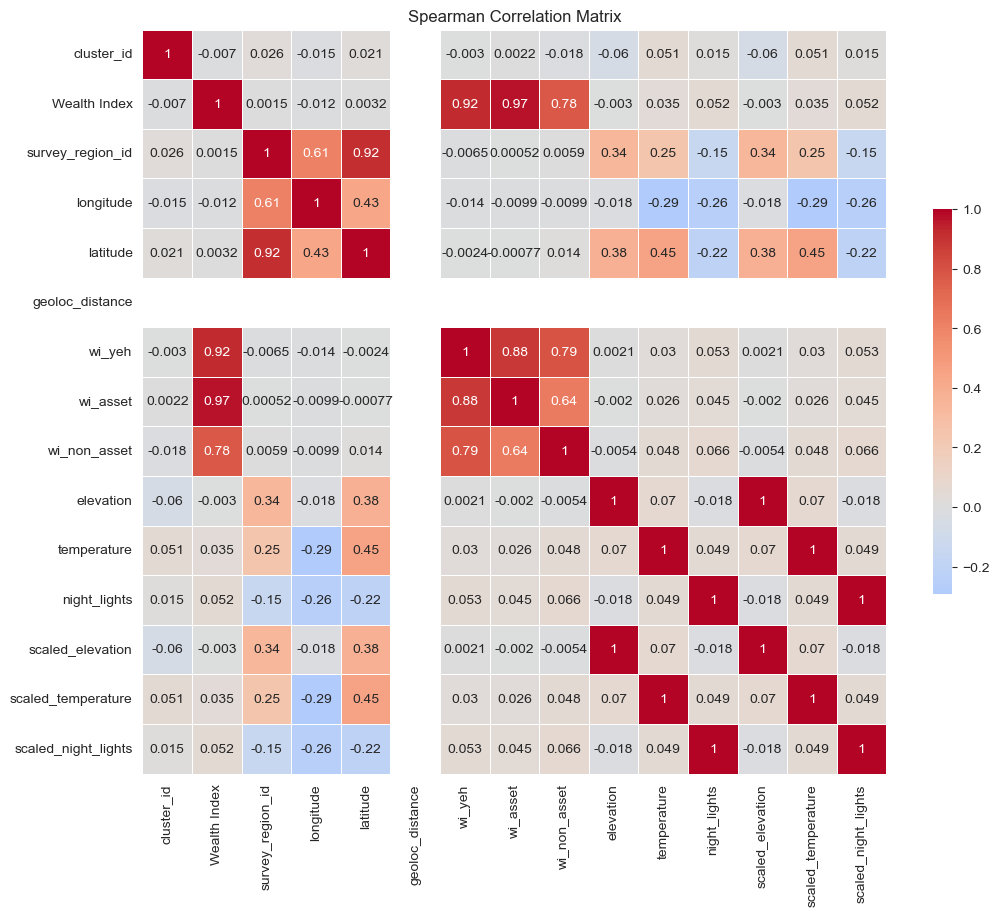

In [71]:


#Numeric columns
numeric_df = all_clusters_gdf.select_dtypes(include=[np.number])

# Spearman correlation matrix
correlation_matrix = numeric_df.corr(method='spearman')

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

#Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# titles and labels
plt.title('Spearman Correlation Matrix')
plt.show()

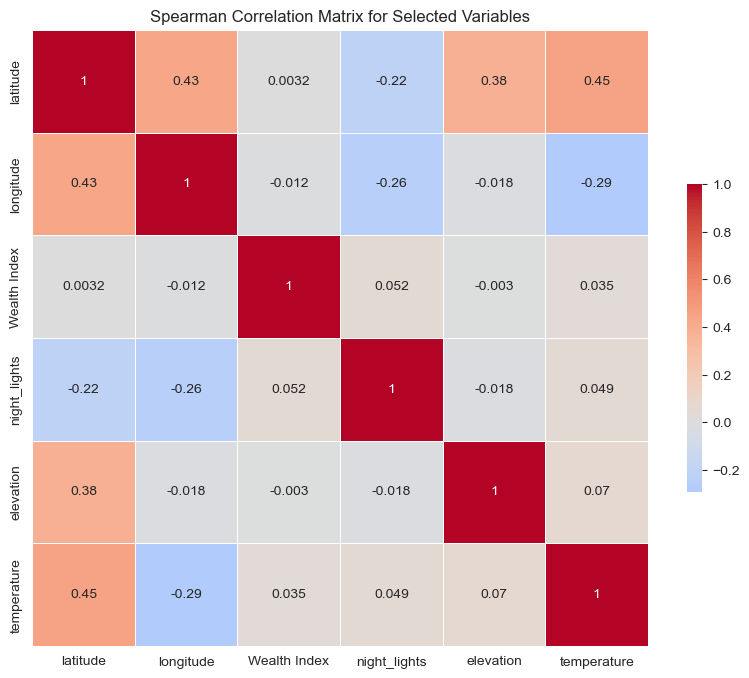

In [72]:
#Selected columns
selected_columns = ['latitude', 'longitude', 'Wealth Index', 'night_lights', 'elevation', 'temperature']
numeric_df = all_clusters_gdf[selected_columns]

# Compute the Spearman correlation matrix for the selected columns
correlation_matrix = numeric_df.corr(method='spearman')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add titles and labels
plt.title('Spearman Correlation Matrix for Selected Variables')
plt.show()

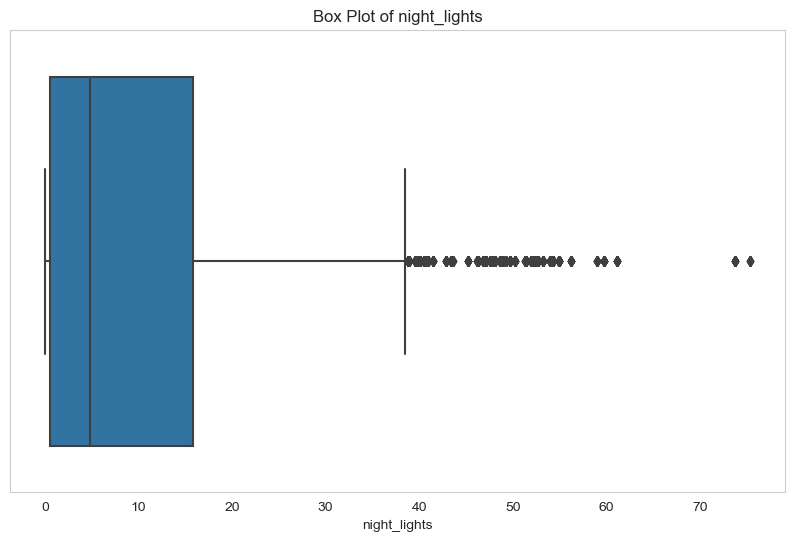

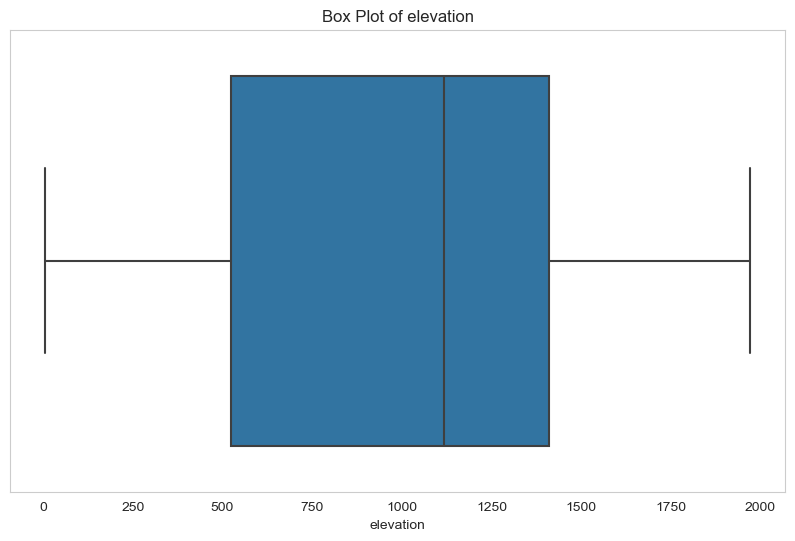

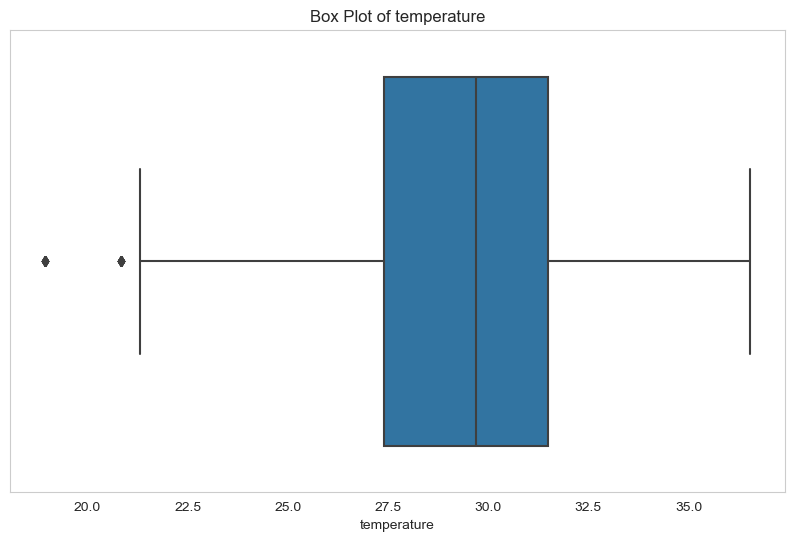

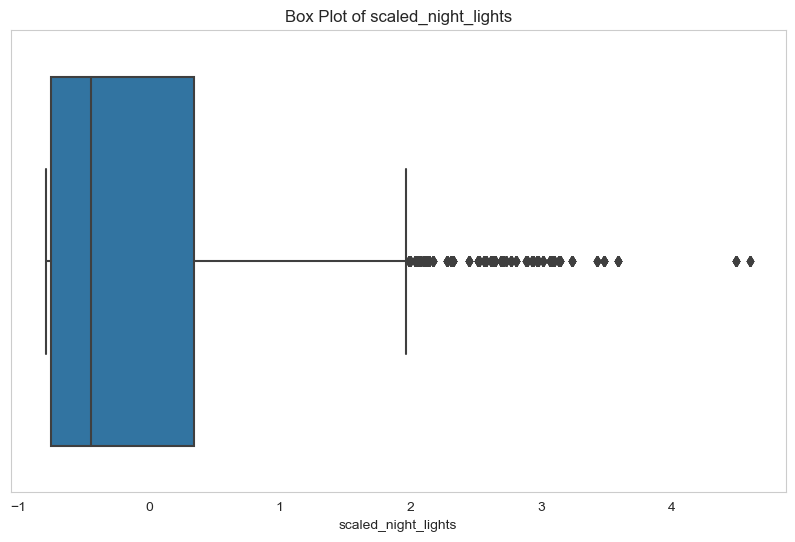

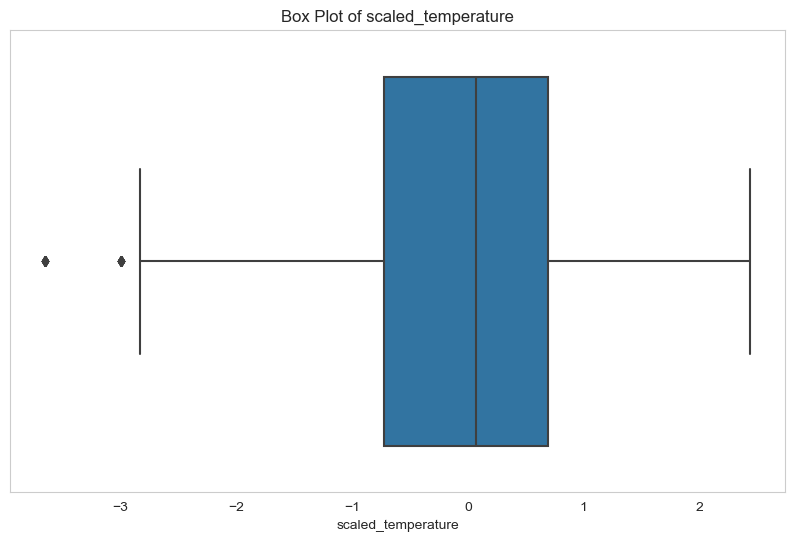

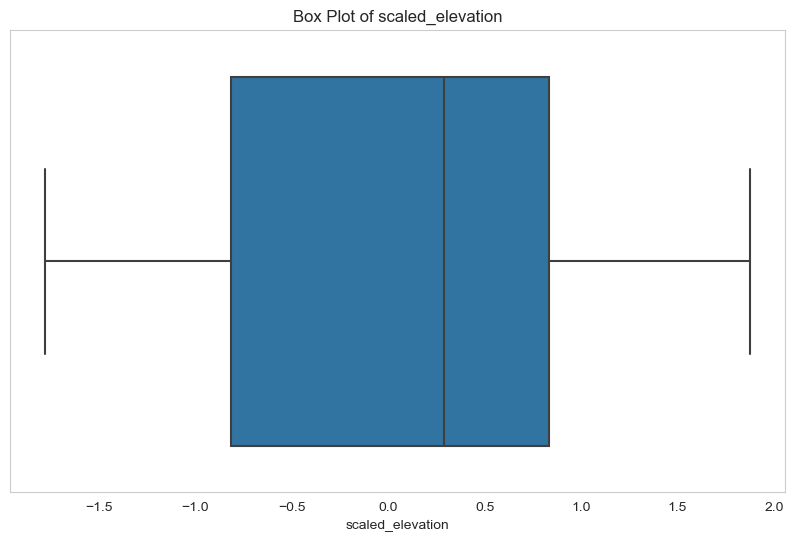

In [73]:
features = ['night_lights', 'elevation', 'temperature', 'scaled_night_lights', 'scaled_temperature', 'scaled_elevation']
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=all_clusters_gdf[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

# Spatial Analysis of Wealth Index

In [61]:
shapefile_gdf = gpd.read_file(shape_file)
shapefile_gdf = shapefile_gdf.to_crs(epsg=4326)

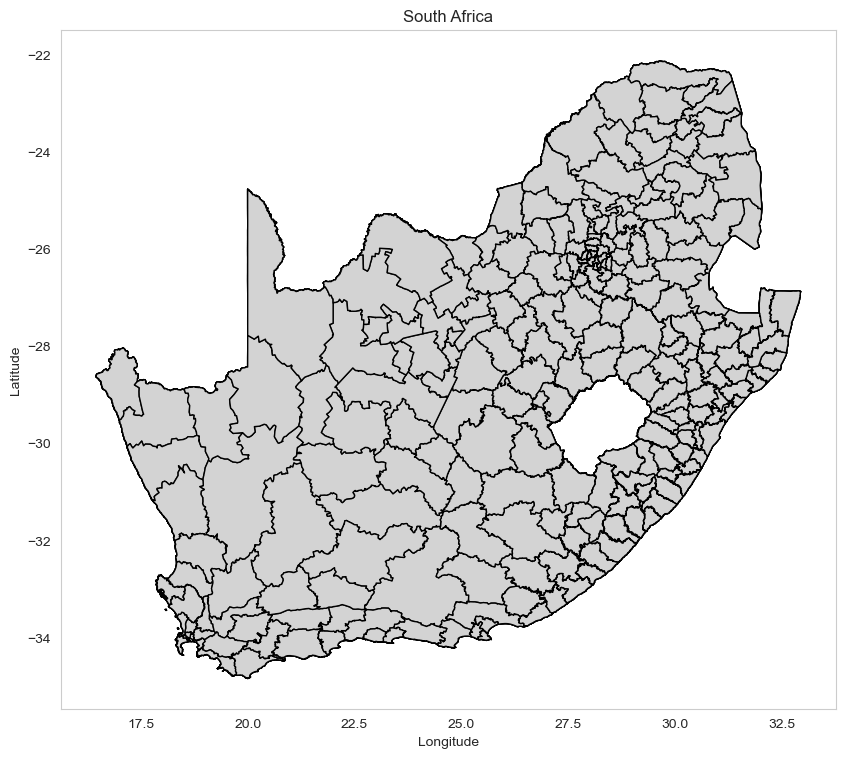

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))
shapefile_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

# Customize the plot
plt.title('South Africa')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

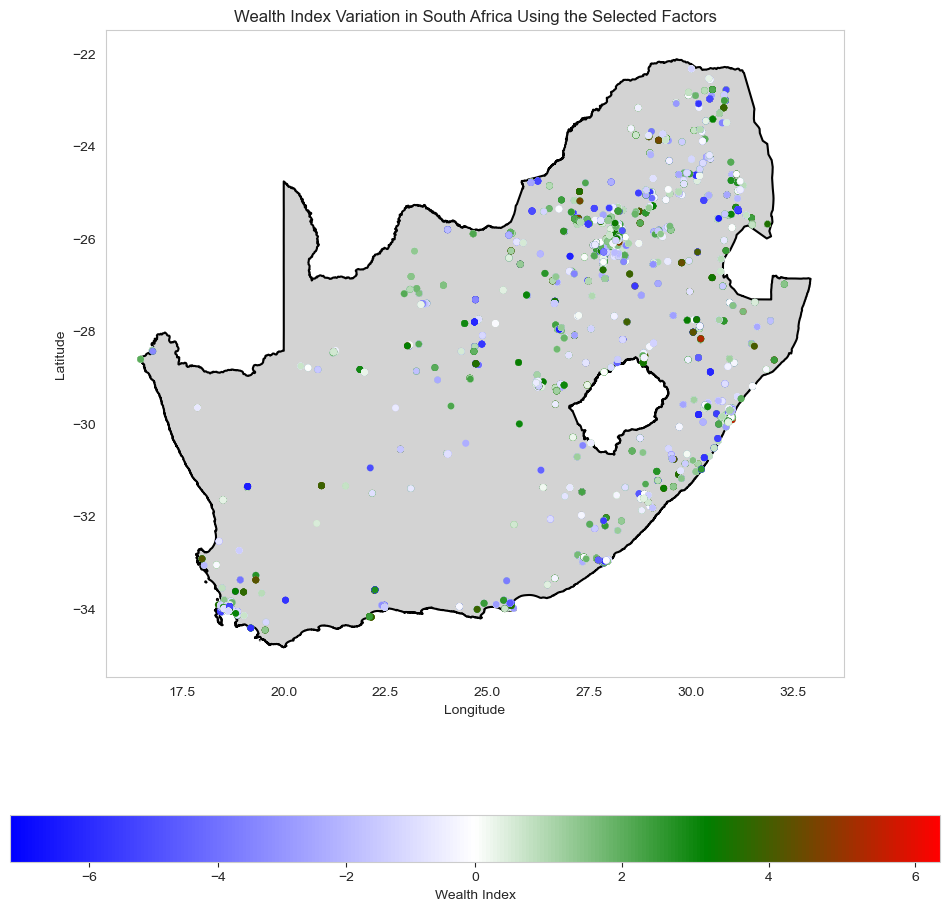

In [63]:
#Check the shapefile is in the right crs
if shapefile_gdf.crs is None:
    shapefile_gdf = shapefile_gdf.set_crs(epsg=4326)  

# Removing inner boundary
outer_boundary_gdf = shapefile_gdf.dissolve()

# Creating GeoDataFrame for the wealth index data
geometry = gpd.points_from_xy(merged_all_df.longitude, merged_all_df.latitude)
geo_df = gpd.GeoDataFrame(merged_all_df, geometry=geometry)
geo_df = geo_df.set_crs(epsg=4326)

# CRS consistency check
geo_df = geo_df.to_crs(shapefile_gdf.crs)

# Colour map
cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_seismic',
    [
        (0.0, 'blue'),      # Minimum value in blue
        (0.5, 'white'),     # 0 value in white
        (0.75, 'green'),    # Values from 3 to 4 in green
        (1.0, 'red')        # Maximum value in red
    ]
)

# Define normalization with vcenter at 0
norm = mcolors.TwoSlopeNorm(vmin=geo_df['Wealth Index'].min(), vcenter=0, vmax=geo_df['Wealth Index'].max())

# Plotting the data
fig, ax = plt.subplots(figsize=(12, 12))

# Grey inner colour
outer_boundary_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1.5)

# plotting
plot = geo_df.plot(column='Wealth Index', ax=ax, legend=True,
                   legend_kwds={'label': "Wealth Index",
                                'orientation': "horizontal"},
                   markersize=15, cmap=cmap, norm=norm)

# legend
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((0.5, -0.05))
    legend.set_title("Wealth Index")
    for text in legend.get_texts():
        text.set_color("black")  # Change the color of legend text

# title, labels
plt.title('Wealth Index Variation in South Africa Using the Selected Factors')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Visualise
plt.show()


# KNN Modeling

KNN Model 1 - Only NTL

In [52]:
#Selecting the features (only nighttime lights) and the target variable
X_knn_ntl = all_clusters_gdf['scaled_night_lights'].values.reshape(-1, 1)
y_knn_ntl = all_clusters_gdf['Wealth Index']

#Instantiating
knn_ntl = KNeighborsRegressor()

# Creating the parameter grid
param_grid_knn_ntl = {
    'n_neighbors': list(range(1, 21)),  # n_neighbors from 1 to 20
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Values for the Minkowski metric
}

# The function used for calculating the RMSE manually
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# using the make_scorer utility function to enable RMSE to be used as the scorer in GridSearchCv
rmse_scorer = make_scorer(rmse, greater_is_better=False)

#Metrics defined
scoring = {'MSE': 'neg_mean_squared_error', 'RMSE': rmse_scorer, 'R2': 'r2'}

#Defing the function for grid search, which returns R² and RMSE for a given test size
def run_grid_search_knn(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    #refit = r2, means that the best hyperparaters are chosen based on the highest R2 across the folds and then the model is trained using these hyperparameters
    grid_search = GridSearchCV(estimator=knn_ntl, param_grid=param_grid_knn_ntl, cv=5, scoring=scoring, refit='R2', verbose=0)
    grid_search.fit(X_train, y_train)
    
    # Predictions and evaluations
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    return {
        'best_params': grid_search.best_params_,
        'best_r2_train': r2_train,
        'rmse_train': rmse_train,
        'r2_test': r2_test,
        'rmse_test': rmse_test,
        'y_test': y_test,
        'y_pred_test': y_pred_test
    }

# Grid search for 20%, 30% and 50% test sizes to assess predictability 
results_20_knn = run_grid_search_knn(X_knn_ntl, y_knn_ntl, 0.2)
results_30_knn = run_grid_search_knn(X_knn_ntl, y_knn_ntl, 0.3)
results_50_knn = run_grid_search_knn(X_knn_ntl, y_knn_ntl, 0.5)

# Creating a dataframe to display R² and RMSE for different test sizes
results_ntl = pd.DataFrame({
    'Test Size': ['20%', '30%', '50%'],
    'R^2': [results_20_knn['r2_test'], results_30_knn['r2_test'], results_50_knn['r2_test']],
    'RMSE': [results_20_knn['rmse_test'], results_30_knn['rmse_test'], results_50_knn['rmse_test']]
})


print("Model Performance Metrics")
print(results_ntl)

# Creating a dataframe to display the best hyperparameters for 20%, 30%, and 50% test sizes
best_params_df = pd.DataFrame({
    'Test Size': ['20%', '30%', '50%'],
    'Best Parameters': [results_20_knn['best_params'], results_30_knn['best_params'], results_50_knn['best_params']]
})

# Print the best hyperparameters
print("\nBest Hyperparameters for each test size:")
print(best_params_df)

# Train the model on 100% of the data using the best parameters from the 20% test size
knn_ntl_full = KNeighborsRegressor(**results_20_knn['best_params'])
knn_ntl_full.fit(X_knn_ntl, y_knn_ntl)

# Using the model that is trained on 100% of the data for predicting and evaluating
y_pred_full = knn_ntl_full.predict(X_knn_ntl)
mse_full = mean_squared_error(y_knn_ntl, y_pred_full)
rmse_full = np.sqrt(mse_full)
r2_full = r2_score(y_knn_ntl, y_pred_full)

# Results displayed
print("\nModel Trained on 100% Data - Performance Metrics:")
print(f"R^2: {r2_full}")
print(f"RMSE: {rmse_full}")


Model Performance Metrics
  Test Size       R^2      RMSE
0       20%  0.318015  1.995617
1       30%  0.293154  2.038302
2       50%  0.247348  2.101892

Best Hyperparameters for each test size:
  Test Size                                    Best Parameters
0       20%  {'metric': 'euclidean', 'n_neighbors': 20, 'p'...
1       30%  {'metric': 'euclidean', 'n_neighbors': 13, 'p'...
2       50%  {'metric': 'euclidean', 'n_neighbors': 20, 'p'...

Model Trained on 100% Data - Performance Metrics:
R^2: 0.4000503120561576
RMSE: 1.8868501001197646


In [68]:
# Print the best hyperparameters with full details
print("Best Hyperparameters for 20% test size:")
print(results_20_knn['best_params'])

print("\nBest Hyperparameters for 30% test size:")
print(results_30_knn['best_params'])

print("\nBest Hyperparameters for 50% test size:")
print(results_50_knn['best_params'])

Best Hyperparameters for 20% test size:
{'metric': 'euclidean', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}

Best Hyperparameters for 30% test size:
{'metric': 'euclidean', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}

Best Hyperparameters for 50% test size:
{'metric': 'euclidean', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}


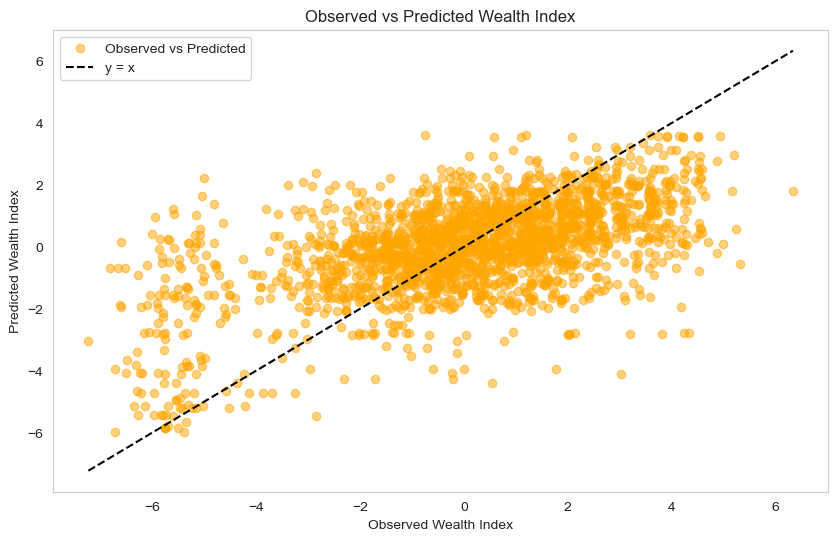

In [69]:
indices = range(len(results_20_knn['y_test']))

plt.figure(figsize=(10, 6))

#A scatterplot for observed and predicted wealth indexes
plt.scatter(results_20['y_test'], results_20['y_pred_test'], label='Observed vs Predicted', alpha=0.5, color='orange')

#labels x and y and title
plt.xlabel('Observed Wealth Index')
plt.ylabel('Predicted Wealth Index')
plt.title('Observed vs Predicted Wealth Index')

# Plotting equal axes and plotting y=x line
min_val = min(results_20_knn['y_test'].min(), results_20_knn['y_pred_test'].min())
max_val = max(results_20_knn['y_test'].max(), results_20_knn['y_pred_test'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')

# Legend
plt.legend()

plt.show()

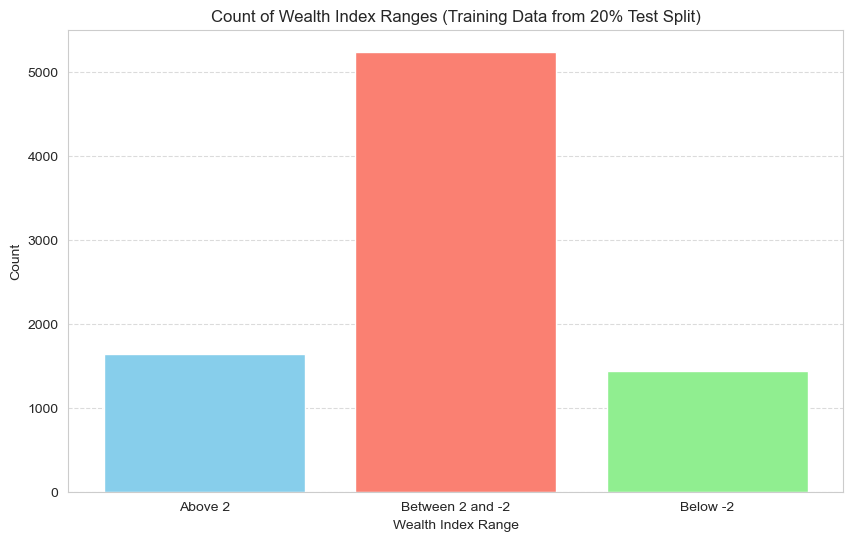

In [70]:
#This function extracts the seperates the training data for 3 classes, wealth index above 2, 
#below 2 and between -2 to 2, and plots the count plot
def analyze_training_data(training_data):
    # Separate the training data based on Wealth Index ranges
    above_2_train = training_data[training_data > 2]
    between_2_and_minus_2_train = training_data[(training_data <= 2) & (training_data >= -2)]
    below_minus_2_train = training_data[training_data < -2]

    # Records the number of instances in each class
    counts_train_20 = {
        'Above 2': above_2_train.shape[0],
        'Between 2 and -2': between_2_and_minus_2_train.shape[0],
        'Below -2': below_minus_2_train.shape[0]
    }

    # Plotting the counts for training data
    plt.figure(figsize=(10, 6))
    plt.bar(counts_train_20.keys(), counts_train_20.values(), color=['skyblue', 'salmon', 'lightgreen'])
    plt.title('Count of Wealth Index Ranges (Training Data from 20% Test Split)')
    plt.xlabel('Wealth Index Range')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    
    plt.show()

# Extracting y_train from the results_20_knn split and analyzing it
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_knn_ntl, y_knn_ntl, test_size=0.2, random_state=42)

# Analyzing the data distribution in the 3 distinct classes
analyze_training_data(y_train_20)

KNN Model 2 - NTL, Temp and Elev

In [111]:
#Selecting the features and the target variable
X_features_knn_all = ['scaled_night_lights', 'scaled_elevation', 'scaled_temperature']
X_knn_all = all_clusters_gdf[X_features_knn_all].values
y_knn_all = all_clusters_gdf['Wealth Index'].values

# The function used for calculating the RMSE manually
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# using the make_scorer utility function to enable RMSE to be used as the scorer in GridSearchCv
rmse_scorer_knn_all = make_scorer(rmse, greater_is_better=False)

# Define the parameter grid
param_grid_knn_all = {
    'n_neighbors': list(range(1, 21)),  # n_neighbors from 1 to 20
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Values for the Minkowski metric
}

# Define scoring metrics
scoring_knn_all = {'MSE': 'neg_mean_squared_error', 'RMSE': rmse_scorer_knn_all, 'R2': 'r2'}

#Defing the function for grid search, which returns R² and RMSE for a given test size
def run_grid_search_knn_all(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    scaler_knn_all = StandardScaler()
    X_train = scaler_knn_all.fit_transform(X_train)
    X_test = scaler_knn_all.transform(X_test)
    
    grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid_knn_all, cv=5, scoring=scoring_knn_all, refit='R2', verbose=0)
    grid_search.fit(X_train, y_train)
    
    # Predictions and evaluations
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    return {
        'best_params': grid_search.best_params_,
        'best_r2_train': r2_train,
        'rmse_train': rmse_train,
        'r2_test': r2_test,
        'rmse_test': rmse_test,
        'y_test': y_test,
        'y_pred_test': y_pred_test
    }

# Run grid search for 20%, 30%, and 50% test sizes
results_20_knn_all = run_grid_search_knn_all(X_knn_all, y_knn_all, 0.2)
results_30_knn_all = run_grid_search_knn_all(X_knn_all, y_knn_all, 0.3)
results_50_knn_all = run_grid_search_knn_all(X_knn_all, y_knn_all, 0.5)

# Display R² and RMSE for different test sizes
results_knn_all = pd.DataFrame({
    'Test Size': ['20%', '30%', '50%'],
    'R^2': [results_20_knn_all['r2_test'], results_30_knn_all['r2_test'], results_50_knn_all['r2_test']],
    'RMSE': [results_20_knn_all['rmse_test'], results_30_knn_all['rmse_test'], results_50_knn_all['rmse_test']]
})

# Print the DataFrame to view the results
print("Model Performance Metrics")
print(results_knn_all)

# Display the best hyperparameters for 20%, 30%, and 50% test sizes
best_params_knn_all_df = pd.DataFrame({
    'Test Size': ['20%', '30%', '50%'],
    'Best Parameters': [results_20_knn_all['best_params'], results_30_knn_all['best_params'], results_50_knn_all['best_params']]
})

# Print the best hyperparameters
print("\nBest Hyperparameters for each test size:")
print(best_params_knn_all_df)

# Train the model on 100% of the data using the best parameters from the 20% test size
knn_ntl_full = KNeighborsRegressor(**results_20_knn_all['best_params'])
scaler_full_knn_all = StandardScaler()
X_knn_all_scaled = scaler_full_knn_all.fit_transform(X_knn_all)
knn_ntl_full.fit(X_knn_all_scaled, y_knn_all)

# Predictions and evaluations with full data
y_pred_full = knn_ntl_full.predict(X_knn_all_scaled)
mse_full = mean_squared_error(y_knn_all, y_pred_full)
rmse_full = np.sqrt(mse_full)
r2_full = r2_score(y_knn_all, y_pred_full)

# Display the RMSE and R² for the model trained on 100% of the data
print("\nModel Trained on 100% Data - Performance Metrics:")
print(f"R^2: {r2_full}")
print(f"RMSE: {rmse_full}")

Model Performance Metrics
  Test Size       R^2      RMSE
0       20%  0.318035  1.995588
1       30%  0.293813  2.037351
2       50%  0.248617  2.100119

Best Hyperparameters for each test size:
  Test Size                                    Best Parameters
0       20%  {'metric': 'euclidean', 'n_neighbors': 20, 'p'...
1       30%  {'metric': 'euclidean', 'n_neighbors': 18, 'p'...
2       50%  {'metric': 'manhattan', 'n_neighbors': 20, 'p'...

Model Trained on 100% Data - Performance Metrics:
R^2: 0.39984474671445036
RMSE: 1.8871733253620364


KNN Model 3 - Only Temp

In [112]:
#Feature and target variable
X_features_temp = ['scaled_temperature']
X_temp = all_clusters_gdf[X_features_temp].values
y_temp = all_clusters_gdf['Wealth Index'].values

# RMSE added
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
# make scorer allows RMSE to be used in grid search
rmse_scorer_temp = make_scorer(rmse, greater_is_better=False)

# metrics for grid search
scoring_temp = {'MSE': 'neg_mean_squared_error', 'RMSE': rmse_scorer_temp, 'R2': 'r2'}

# parameter grid
param_grid_temp = {
    'n_neighbors': list(range(1, 21)),  # n_neighbors from 1 to 20
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Values for the Minkowski metric
}

# defined a function that will features and target and test size and return the metrics along with the best parameters
def run_grid_search_temp(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid_temp, cv=5, scoring=scoring_temp, refit='R2', verbose=0)
    grid_search.fit(X_train, y_train)
    
    # Predictions and evaluations
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    return {
        'best_params': grid_search.best_params_,
        'best_r2_train': r2_train,
        'rmse_train': rmse_train,
        'r2_test': r2_test,
        'rmse_test': rmse_test,
        'y_test': y_test,
        'y_pred_test': y_pred_test
    }

# calling the function
results_20_temp = run_grid_search_temp(X_temp, y_temp, 0.2)
results_30_temp = run_grid_search_temp(X_temp, y_temp, 0.3)
results_50_temp = run_grid_search_temp(X_temp, y_temp, 0.5)

# dataframes for display
results_temp = pd.DataFrame({
    'Test Size': ['20%', '30%', '50%'],
    'R^2': [results_20_temp['r2_test'], results_30_temp['r2_test'], results_50_temp['r2_test']],
    'RMSE': [results_20_temp['rmse_test'], results_30_temp['rmse_test'], results_50_temp['rmse_test']]
})

# Print the DataFrame to view the results
print("Model Performance Metrics")
print(results_temp)

# Display the best hyperparameters for 20%, 30%, and 50% test sizes
best_params_df = pd.DataFrame({
    'Test Size': ['20%', '30%', '50%'],
    'Best Parameters': [results_20_temp['best_params'], results_30_temp['best_params'], results_50_temp['best_params']]
})

# Print the best hyperparameters
print("\nBest Hyperparameters for each test size:")
print(best_params_df)

# Train the model on 100% of the data using the best parameters from the 20% test size
knn_temp_full = KNeighborsRegressor(**results_20_temp['best_params'])
knn_temp_full.fit(X_temp, y_temp)

# Predictions and evaluations with full data
y_pred_full = knn_temp_full.predict(X_temp)
mse_full = mean_squared_error(y_temp, y_pred_full)
rmse_full = np.sqrt(mse_full)
r2_full = r2_score(y_temp, y_pred_full)

# Display the RMSE and R² for the model trained on 100% of the data
print("\nModel Trained on 100% Data - Performance Metrics:")
print(f"R^2: {r2_full}")
print(f"RMSE: {rmse_full}")

Model Performance Metrics
  Test Size       R^2      RMSE
0       20%  0.263083  2.074431
1       30%  0.242861  2.109569
2       50%  0.205273  2.159843

Best Hyperparameters for each test size:
  Test Size                                    Best Parameters
0       20%  {'metric': 'euclidean', 'n_neighbors': 19, 'p'...
1       30%  {'metric': 'euclidean', 'n_neighbors': 20, 'p'...
2       50%  {'metric': 'euclidean', 'n_neighbors': 20, 'p'...

Model Trained on 100% Data - Performance Metrics:
R^2: 0.32340186978727137
RMSE: 2.0037585106926725


KNN Model 4 - Elevation

In [114]:
#Features and target variable assigned
X_features_elev = ['scaled_elevation']
X_elev = all_clusters_gdf[X_features_elev].values
y_elev = all_clusters_gdf['Wealth Index'].values

# RMSE added manually
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# allows rmse value to be used in grid search
rmse_scorer_elev = make_scorer(rmse, greater_is_better=False)

# parameter grid
param_grid_elev = {
    'n_neighbors': list(range(1, 21)),  # n_neighbors from 1 to 20
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Values for the Minkowski metric
}

# metrics to be used in grid search
scoring_elev = {'MSE': 'neg_mean_squared_error', 'RMSE': rmse_scorer_elev, 'R2': 'r2'}

# Function to run grid search and return R² and RMSE for a given test size
def run_grid_search_elev(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid_elev, cv=5, scoring=scoring_elev, refit='R2', verbose=0)
    grid_search.fit(X_train, y_train)
    
    # Predictions and evaluations
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    return {
        'best_params': grid_search.best_params_,
        'best_r2_train': r2_train,
        'rmse_train': rmse_train,
        'r2_test': r2_test,
        'rmse_test': rmse_test,
        'y_test': y_test,
        'y_pred_test': y_pred_test
    }

# calling the function
results_20_elev = run_grid_search_elev(X_elev, y_elev, 0.2)
results_30_elev = run_grid_search_elev(X_elev, y_elev, 0.3)
results_50_elev = run_grid_search_elev(X_elev, y_elev, 0.5)

# creating dfs to display R² and RMSE for different test sizes
results_elev = pd.DataFrame({
    'Test Size': ['20%', '30%', '50%'],
    'R^2': [results_20_elev['r2_test'], results_30_elev['r2_test'], results_50_elev['r2_test']],
    'RMSE': [results_20_elev['rmse_test'], results_30_elev['rmse_test'], results_50_elev['rmse_test']]
})

# Print the DataFrame to view the results
print("Model Performance Metrics")
print(results_elev)

# Display the best hyperparameters for 20%, 30%, and 50% test sizes
best_params_df = pd.DataFrame({
    'Test Size': ['20%', '30%', '50%'],
    'Best Parameters': [results_20_elev['best_params'], results_30_elev['best_params'], results_50_elev['best_params']]
})

# Print the best hyperparameters
print("\nBest Hyperparameters for each test size:")
print(best_params_df)

#training the model with full data using parameters from the 20% set
knn_elev_full = KNeighborsRegressor(**results_20_elev['best_params'])
knn_elev_full.fit(X_elev, y_elev)

#Predictions and evaluations with full data
y_pred_full = knn_elev_full.predict(X_elev)
mse_full = mean_squared_error(y_elev, y_pred_full)
rmse_full = np.sqrt(mse_full)
r2_full = r2_score(y_elev, y_pred_full)

# Display the RMSE and R² for the model trained on 100% of the data
print("\nModel Trained on 100% Data - Performance Metrics:")
print(f"R^2: {r2_full}")
print(f"RMSE: {rmse_full}")


Model Performance Metrics
  Test Size       R^2      RMSE
0       20%  0.259762  2.079100
1       30%  0.233378  2.122739
2       50%  0.205014  2.160196

Best Hyperparameters for each test size:
  Test Size                                    Best Parameters
0       20%  {'metric': 'euclidean', 'n_neighbors': 20, 'p'...
1       30%  {'metric': 'euclidean', 'n_neighbors': 20, 'p'...
2       50%  {'metric': 'euclidean', 'n_neighbors': 20, 'p'...

Model Trained on 100% Data - Performance Metrics:
R^2: 0.30003368912252903
RMSE: 2.0380674474608496


# CNN Modeling

In [64]:
#preventing full memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

CNN Model 1 - Using Nighttime Lights

In [74]:
#Function to crop at the cluster locations, crop size = 20
def crop_and_save_images(image_path, cluster_info, output_dir, crop_size=20):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # load the nighttime lights image
    with rasterio.open(image_path) as src:
        for i, row in cluster_info.iterrows():
            # Obtain the cluster coordinates
            lon, lat = row['longitude'], row['latitude']
            wealth_index = row['Wealth Index']

            #Converting the lat, lon to image co-ordinates
            row, col = src.index(lon, lat)
            
            # to get the crop boundaries
            left = col - crop_size // 2
            top = row - crop_size // 2
            right = left + crop_size
            bottom = top + crop_size

            # Ensure the crop is within image bounds
            if left < 0 or top < 0 or right > src.width or bottom > src.height:
                print(f"Skipping cluster {i}: crop out of bounds")
                continue

            # window refers to rectangular subset of raster data
            window = rasterio.windows.Window(left, top, crop_size, crop_size) #small rectangle that spans from left, top and is of 20 by 20
            cropped_image = src.read(window=window) #pixel values of the cropped image within the specified window are being stored
            
            #Removing the band dimension as it is easy to work with 
            if cropped_image.shape[0] == 1:
                cropped_image = np.squeeze(cropped_image, axis=0)
            
            # Normalizing the image and convert to uint8 (0-255 range)
            cropped_image = (255 * (cropped_image - cropped_image.min()) / (cropped_image.ptp() + 1e-6)).astype(np.uint8) #.ptp = max()-min()
            
            #PIL = image object, Convert to PIL image and save
            cropped_image_pil = Image.fromarray(cropped_image)
            cropped_image_pil.save(os.path.join(output_dir, f'cluster_{i}_label_{wealth_index:.2f}.png'))

#Defining the image path and the directory
image_path = "D:/Extended Research Project/Google-Earth-Engine/SouthAfrica_Nightlights_2015-2017.tif"  
output_dir = 'cropped_images'  

# finally, calling the function
crop_and_save_images(image_path, all_clusters_gdf, output_dir)

In [101]:
# Loading image and converting it into a normalized grayscale image, and then as a numpy array
def load_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = np.array(image)
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=-1)  # channel dimension to prepare for CNN
    return image

# Extracting labels from filename
def parse_filename(filename):
    parts = filename.split('_')
    label = float(parts[-1].split('.')[0])
    return label

#Loading images and labels from the directory
def load_dataset(image_dir):
    images = []
    labels = []
    filenames = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            image = load_image(image_path)
            label = parse_filename(filename)
            images.append(image)
            labels.append(label)
            filenames.append(filename)
    return np.array(images), np.array(labels), filenames

# Load all images and labels
images, labels, filenames = load_dataset('cropped_images')

# Extract site IDs from filenames
site_ids = np.array([filename.split('_')[1] for filename in filenames])

# splitting data at the cluster level and ensuring there is no data leakage by seperating the site ids from training and testing sets
def create_split(images, labels, site_ids, test_size):
    unique_sites = np.unique(site_ids)
    train_sites, test_sites = train_test_split(unique_sites, test_size=test_size, random_state=42)

    train_mask = np.isin(site_ids, train_sites)
    test_mask = np.isin(site_ids, test_sites)

    train_images = images[train_mask]
    train_labels = labels[train_mask]
    train_filenames = np.array(filenames)[train_mask]

    test_images = images[test_mask]
    test_labels = labels[test_mask]
    test_filenames = np.array(filenames)[test_mask]

    return (train_images, train_labels, train_filenames), (test_images, test_labels, test_filenames)

# 20%, 30%, and 50% test splits for assessing predictive ability
(train_images_20_ntl, train_labels_20_ntl, train_filenames_20_ntl), (test_images_20_ntl, test_labels_20_ntl, test_filenames_20_ntl) = create_split(images, labels, site_ids, test_size=0.2)
(train_images_30_ntl, train_labels_30_ntl, train_filenames_30_ntl), (test_images_30_ntl, test_labels_30_ntl, test_filenames_30_ntl) = create_split(images, labels, site_ids, test_size=0.3)
(train_images_50_ntl, train_labels_50_ntl, train_filenames_50_ntl), (test_images_50_ntl, test_labels_50_ntl, test_filenames_50_ntl) = create_split(images, labels, site_ids, test_size=0.5)



print("Preprocessing complete! Images have been split for 20%, 30%, and 50% test sizes.")

Preprocessing complete! Images have been split for 20%, 30%, and 50% test sizes.


In [78]:

# images and labels are being converted to datasets (dataset = tuple) 
def create_tf_dataset(images, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create TensorFlow datasets for each split
train_dataset_20_ntl = create_tf_dataset(train_images_20_ntl, train_labels_20_ntl)
test_dataset_20_ntl = create_tf_dataset(test_images_20_ntl, test_labels_20_ntl, shuffle=False) #shuffling false bc we dont want data leakage

train_dataset_30_ntl = create_tf_dataset(train_images_30_ntl, train_labels_30_ntl)
test_dataset_30_ntl = create_tf_dataset(test_images_30_ntl, test_labels_30_ntl, shuffle=False)

train_dataset_50_ntl = create_tf_dataset(train_images_50_ntl, train_labels_50_ntl)
test_dataset_50_ntl = create_tf_dataset(test_images_50_ntl, test_labels_50_ntl, shuffle=False)


In [79]:
# Model architecture, the hyper model
def build_model_ntl(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_filters', min_value=16, max_value=64, step=16), #hyper parameter range defined
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=(train_images_20_ntl.shape[1], train_images_20_ntl.shape[2], 1)
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Model evaluation function defined
def evaluate_model(model, dataset):
    y_true, y_pred = [], []
    for X_batch, y_batch in dataset:
        y_true.extend(y_batch.numpy())
        y_pred.extend(model.predict(X_batch).flatten())
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, r2, mae

# Hyper parameter tuning using keras tuner
def perform_tuning(train_dataset, test_dataset, holdout_name):
    tuner = kt.RandomSearch(
        build_model_ntl,
        objective='val_loss',
        max_trials=5,
        directory='my_dir',
        project_name=f'cnn_optimization_{holdout_name}'
    )
    
    tuner.search(
        train_dataset,
        validation_data=test_dataset,
        epochs=50,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],
        verbose=1
    ) #early stopping to prevent overfitting
    
    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model

# Function to run the full experiment for a given holdout proportion
def run_experiment(train_dataset, test_dataset, holdout_name):
    # Perform hyperparameter tuning
    best_model = perform_tuning(train_dataset, test_dataset, holdout_name)
    
    # Evaluate the model on the test dataset
    rmse, r2, mae = evaluate_model(best_model, test_dataset)
    
    print(f"\nResults for {holdout_name} Holdout:")
    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")
    return rmse, r2, mae

# Running the experiments for different holdout sets
results = {}

# Experimenting with 20% held-out set
results['20% Holdout'] = run_experiment(train_dataset_20_ntl, test_dataset_20_ntl, '20_percent')

# Experimenting with 30% held-out set
results['30% Holdout'] = run_experiment(train_dataset_30_ntl, test_dataset_30_ntl, '30_percent')

# Experimenting with 50% held-out set
results['50% Holdout'] = run_experiment(train_dataset_50_ntl, test_dataset_50_ntl, '50_percent')

# Printing all results
print("\nFinal Results:")
for key, value in results.items():
    print(f"{key}: RMSE={value[0]:.4f}, R²={value[1]:.4f}, MAE={value[2]:.4f}")

Reloading Tuner from my_dir\cnn_optimization_20_percent\tuner0.json



C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

In [84]:
# converting images and labels to datasets
def create_tf_dataset(images, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create TensorFlow datasets for each split
train_dataset_20_ntl = create_tf_dataset(train_images_20_ntl, train_labels_20_ntl)
test_dataset_20_ntl = create_tf_dataset(test_images_20_ntl, test_labels_20_ntl, shuffle=False)

train_dataset_30_ntl = create_tf_dataset(train_images_30_ntl, train_labels_30_ntl)
test_dataset_30_ntl = create_tf_dataset(test_images_30_ntl, test_labels_30_ntl, shuffle=False)

train_dataset_50_ntl = create_tf_dataset(train_images_50_ntl, train_labels_50_ntl)
test_dataset_50_ntl = create_tf_dataset(test_images_50_ntl, test_labels_50_ntl, shuffle=False)

# combining the train and test to create a dataset that contains all the images
train_images_full = np.concatenate([train_images_20_ntl, test_images_20_ntl])
train_labels_full = np.concatenate([train_labels_20_ntl, test_labels_20_ntl])
train_dataset_full_ntl = create_tf_dataset(train_images_full, train_labels_full, shuffle=True)

In [85]:
#function defined to get the model fit using 100% training data
def train_on_full_data(train_dataset, holdout_name):
    # Perform hyperparameter tuning on full data
    best_model = perform_tuning(train_dataset, train_dataset, holdout_name)  # Using the same data for training and validation since there's no separate holdout
    
    # Evaluate the model on 100% training data
    rmse, r2, mae = evaluate_model(best_model, train_dataset)
    
    print(f"\nResults for {holdout_name} with 100% Training Data:")
    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")
    return rmse, r2, mae


# Training the model using all the data, and evaluating 
results['100% Training Data'] = train_on_full_data(train_dataset_full_ntl, '100_percent')

# Results of all the different sets displayed
print("\nFinal Results:")
for key, value in results.items():
    print(f"{key}: RMSE={value[0]:.4f}, R²={value[1]:.4f}, MAE={value[2]:.4f}")

Reloading Tuner from my_dir\cnn_optimization_100_percent\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━

CNN Model 2 - Using all inputs

In [95]:
#Function to crop at the cluster locations, crop size = 20
def crop_and_save_combined_images(ntl_image_path, altitude_image_path, temperature_image_path, cluster_info, output_dir, crop_size=20):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    #opening all three raster files
    with rasterio.open(ntl_image_path) as ntl_src, \
         rasterio.open(altitude_image_path) as alt_src, \
         rasterio.open(temperature_image_path) as temp_src:

        #extracting the transformation matric, crs and shape of the ntl so that altitude and temperature can be aligned in the same way
        dest_transform = ntl_src.transform
        dest_crs = ntl_src.crs
        dest_shape = ntl_src.shape

        # empty numpy arrays for reprojected images
        alt_reprojected = np.empty(dest_shape, dtype=alt_src.dtypes[0])
        temp_reprojected = np.empty(dest_shape, dtype=temp_src.dtypes[0])

        # Reproject altitude image to match night lights image
        reproject(
            source=rasterio.band(alt_src, 1),
            destination=alt_reprojected,
            src_transform=alt_src.transform,
            src_crs=alt_src.crs,
            dst_transform=dest_transform,
            dst_crs=dest_crs,
            resampling=Resampling.bilinear
        ) #Re-sampling: interpolate pixel vals during reprojection 

        # Reproject temperature image to match night lights image
        reproject(
            source=rasterio.band(temp_src, 1),
            destination=temp_reprojected,
            src_transform=temp_src.transform,
            src_crs=temp_src.crs,
            dst_transform=dest_transform,
            dst_crs=dest_crs,
            resampling=Resampling.bilinear
        )

        for i, row in cluster_info.iterrows():
            # Get the cluster coordinates
            lon, lat = row['longitude'], row['latitude']
            wealth_index = row['Wealth Index']

            # Converting lat, lon to image coordinates
            ntl_row, ntl_col = ntl_src.index(lon, lat)

            # crop boundaries
            left = ntl_col - crop_size // 2
            top = ntl_row - crop_size // 2
            right = left + crop_size
            bottom = top + crop_size

            # Ensure the crop is within image bounds
            if left < 0 or top < 0 or right > ntl_src.width or bottom > ntl_src.height:
                print(f"Skipping cluster {i}: crop out of bounds")
                continue

            # window = small rectangle that spans from left, top and is of 20 by 20
            ntl_window = rasterio.windows.Window(left, top, crop_size, crop_size)
            ntl_crop = ntl_src.read(window=ntl_window)
            alt_crop = alt_reprojected[top:bottom, left:right]
            temp_crop = temp_reprojected[top:bottom, left:right]

            # Ensuring each crop has the correct shape (crop_size, crop_size)
            if ntl_crop.shape[0] == 1:
                ntl_crop = np.squeeze(ntl_crop, axis=0)
            if alt_crop.shape[0] == 1:
                alt_crop = np.squeeze(alt_crop, axis=0)
            if temp_crop.shape[0] == 1:
                temp_crop = np.squeeze(temp_crop, axis=0)

            # Normalize and convert to uint8 (0-255 range). ptp() = max()-min()
            ntl_crop = (255 * (ntl_crop - ntl_crop.min()) / (ntl_crop.ptp() + 1e-6)).astype(np.uint8)
            alt_crop = (255 * (alt_crop - alt_crop.min()) / (alt_crop.ptp() + 1e-6)).astype(np.uint8)
            temp_crop = (255 * (temp_crop - temp_crop.min()) / (temp_crop.ptp() + 1e-6)).astype(np.uint8)

            # Stacking the cropped pictures to create a multi channel image 
            combined_image = np.stack((ntl_crop, alt_crop, temp_crop), axis=-1)
            
            # Converting to PIL image object and saving it to the directory
            combined_image_pil = Image.fromarray(combined_image)
            combined_image_pil.save(os.path.join(output_dir, f'cluster_{i}_label_{wealth_index:.2f}.png'))


output_dir = 'cropped_images_model2'  # Directory to save the cropped images

#calling the function
crop_and_save_combined_images(night_lights_file, elevation_file, temp_file, all_clusters_gdf, output_dir)

In [98]:

# Function to load and preprocess images
def load_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = np.array(image) #converting image to numpy array
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=-1)  # Adding the channel dimension
    return image

# Function to parse the label from the filename
def parse_filename(filename):
    parts = filename.split('_')
    label = float(parts[-1].split('.')[0])
    return label

# Function to load images and labels from a directory
def load_dataset(image_dir):
    images = []
    labels = []
    filenames = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            image = load_image(image_path)
            label = parse_filename(filename)
            images.append(image)
            labels.append(label)
            filenames.append(filename)
    return np.array(images), np.array(labels), filenames

# Loading all images and labels
images, labels, filenames = load_dataset('cropped_images_model2')

# Extracting site IDs from filenames
site_ids = np.array([filename.split('_')[1] for filename in filenames])

# Define a function to create train and test splits for a given test size
def create_split(images, labels, site_ids, test_size):
    unique_sites = np.unique(site_ids)
    train_sites, test_sites = train_test_split(unique_sites, test_size=test_size, random_state=42)

    train_mask = np.isin(site_ids, train_sites) #creates a boolean mask
    test_mask = np.isin(site_ids, test_sites)

    train_images = images[train_mask] #images corresponding to true values are included
    train_labels = labels[train_mask] #same
    train_filenames = np.array(filenames)[train_mask]

    test_images = images[test_mask]
    test_labels = labels[test_mask]
    test_filenames = np.array(filenames)[test_mask]

    return (train_images, train_labels, train_filenames), (test_images, test_labels, test_filenames)

(train_images_20_all, train_labels_20_all, train_filenames_20_all), (test_images_20_all, test_labels_20_all, test_filenames_20_all) = create_split(images, labels, site_ids, test_size=0.2)
(train_images_30_all, train_labels_30_all, train_filenames_30_all), (test_images_30_all, test_labels_30_all, test_filenames_30_all) = create_split(images, labels, site_ids, test_size=0.3)
(train_images_50_all, train_labels_50_all, train_filenames_50_all), (test_images_50_all, test_labels_50_all, test_filenames_50_all) = create_split(images, labels, site_ids, test_size=0.5)





print("Preprocessing complete! Images have been split for 20%, 30%, and 50% test sizes.")

Preprocessing complete! Images have been split for 20%, 30%, and 50% test sizes.


In [99]:
# Printing the shape of training and test sets for the 20% split
print("20% Train Images Shape:", train_images_20_all.shape)
print("20% Train Labels Shape:", train_labels_20_all.shape)
print("20% Test Images Shape:", test_images_20_all.shape)
print("20% Test Labels Shape:", test_labels_20_all.shape)

# Printing the shape of training and test sets for the 30% split
print("30% Train Images Shape:", train_images_30_all.shape)
print("30% Train Labels Shape:", train_labels_30_all.shape)
print("30% Test Images Shape:", test_images_30_all.shape)
print("30% Test Labels Shape:", test_labels_30_all.shape)

# Printing the shape of training and test sets for the 50% split
print("50% Train Images Shape:", train_images_50_all.shape)
print("50% Train Labels Shape:", train_labels_50_all.shape)
print("50% Test Images Shape:", test_images_50_all.shape)
print("50% Test Labels Shape:", test_labels_50_all.shape)


20% Train Images Shape: (8333, 20, 20, 1)
20% Train Labels Shape: (8333,)
20% Test Images Shape: (2084, 20, 20, 1)
20% Test Labels Shape: (2084,)
30% Train Images Shape: (7291, 20, 20, 1)
30% Train Labels Shape: (7291,)
30% Test Images Shape: (3126, 20, 20, 1)
30% Test Labels Shape: (3126,)
50% Train Images Shape: (5208, 20, 20, 1)
50% Train Labels Shape: (5208,)
50% Test Images Shape: (5209, 20, 20, 1)
50% Test Labels Shape: (5209,)


In [100]:
train_images_full_all = np.concatenate([train_images_20_all, test_images_20_all])
train_labels_full_all = np.concatenate([train_labels_20_all, test_labels_20_all])


# Function to create TensorFlow datasets
def create_tf_dataset(images, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Calling Function
train_dataset_20_all = create_tf_dataset(train_images_20_all, train_labels_20_all)
test_dataset_20_all = create_tf_dataset(test_images_20_all, test_labels_20_all, shuffle=False)

train_dataset_30_all = create_tf_dataset(train_images_30_all, train_labels_30_all)
test_dataset_30_all= create_tf_dataset(test_images_30_all, test_labels_30_all, shuffle=False)

train_dataset_50_all = create_tf_dataset(train_images_50_all, train_labels_50_all)
test_dataset_50_all = create_tf_dataset(test_images_50_all, test_labels_50_all, shuffle=False)

train_dataset_full_all= create_tf_dataset(train_images_full_all, train_labels_full_all, shuffle=True)

In [102]:
#model architecture, same architecture like model 1
def build_model_a(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=(train_images_20_ntl.shape[1], train_images_20_ntl.shape[2], 1)
    )) #(crop size,crop size,1) = (20,20,1)
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Model evaluation function
def evaluate_model(model, dataset):
    y_true, y_pred = [], []
    for X_batch, y_batch in dataset:
        y_true.extend(y_batch.numpy())
        y_pred.extend(model.predict(X_batch).flatten())
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, r2, mae

# Hyper tuning using keras tuner
def perform_tuning(train_dataset, test_dataset, holdout_name):
    tuner = kt.RandomSearch(
        build_model_a,
        objective='val_loss',
        max_trials=5,
        directory='my_dir',
        project_name=f'cnn_optimization_{holdout_name}_a'
    )
    
    tuner.search(
        train_dataset,
        validation_data=test_dataset,
        epochs=50,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],
        verbose=1
    )
    
    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model

# Function to run the full experiment for a given holdout proportion
def run_experiment(train_dataset, test_dataset, holdout_name):
    # Perform hyperparameter tuning
    best_model = perform_tuning(train_dataset, test_dataset, holdout_name)
    
    # Evaluate the model on the test dataset
    rmse, r2, mae = evaluate_model(best_model, test_dataset)
    
    print(f"\nResults for {holdout_name} Holdout:")
    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")
    return rmse, r2, mae


# Running the experiments for different holdout sets
results_all = {}

# Experimenting with 20% held-out set
results_all['20% Holdout'] = run_experiment(train_dataset_20_all, test_dataset_20_all, '20_percent')

# Experimenting with 30% held-out set
results_all['30% Holdout'] = run_experiment(train_dataset_30_all, test_dataset_30_all, '30_percent')

# Experimenting with 50% held-out set
results_all['50% Holdout'] = run_experiment(train_dataset_50_all, test_dataset_50_all, '50_percent')

# Displaying all results
print("\nFinal Results:")
for key, value in results_all.items():
    print(f"{key}: RMSE={value[0]:.4f}, R²={value[1]:.4f}, MAE={value[2]:.4f}")



Trial 5 Complete [00h 00m 34s]
val_loss: 4.377490997314453

Best val_loss So Far: 3.2876527309417725
Total elapsed time: 00h 06m 10s


C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

In [103]:
#training the model on 100% data to get the model fit
def train_on_full_data(train_dataset, holdout_name):
    # Perform hyperparameter tuning on full data
    best_model = perform_tuning(train_dataset, train_dataset, holdout_name)  # Using the same data for training and validation since there's no separate holdout
    
    # Evaluate the model on the full training data
    rmse, r2, mae = evaluate_model(best_model, train_dataset)
    
    print(f"\nResults for {holdout_name} with 100% Training Data:")
    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")
    return rmse, r2, mae


# Assigning function call to a dictionary entry
results_all['100% Training Data'] = train_on_full_data(train_dataset_full_all, '100_percent')

# Displaying results of all the sets
print("\nFinal Results:")
for key, value in results_all.items():
    print(f"{key}: RMSE={value[0]:.4f}, R²={value[1]:.4f}, MAE={value[2]:.4f}")

Trial 5 Complete [00h 02m 05s]
val_loss: 2.6737852096557617

Best val_loss So Far: 2.6624257564544678
Total elapsed time: 00h 14m 45s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

CNN Model 3 - Temperature

In [85]:
#Same cropping mechanism like ntl
def crop_and_save_images(image_path, cluster_info, output_dir, crop_size=20):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # loading temp raster image
    with rasterio.open(image_path) as src:
        for i, row in cluster_info.iterrows():
            # Get the cluster coordinates
            lon, lat = row['longitude'], row['latitude']
            wealth_index = row['Wealth Index']

            # lat lon to pixel co-ordinates
            row, col = src.index(lon, lat)
            
            # Calculate crop boundaries
            left = col - crop_size // 2
            top = row - crop_size // 2
            right = left + crop_size
            bottom = top + crop_size

            # Ensure the crop is within image bounds
            if left < 0 or top < 0 or right > src.width or bottom > src.height:
                print(f"Skipping cluster {i}: crop out of bounds")
                continue

            # Read the image data for the crop
            window = rasterio.windows.Window(left, top, crop_size, crop_size)
            cropped_image = src.read(window=window)
            
            #Removing dimension if requirement met
            if cropped_image.shape[0] == 1:
                cropped_image = np.squeeze(cropped_image, axis=0)
            
            # Normalize and convert to uint8
            cropped_image = (255 * (cropped_image - cropped_image.min()) / (cropped_image.ptp() + 1e-6)).astype(np.uint8)
            
            # Convert to PIL image and save
            cropped_image_pil = Image.fromarray(cropped_image)
            cropped_image_pil.save(os.path.join(output_dir, f'cluster_{i}_label_{wealth_index:.2f}.png'))


output_dir = 'cropped_images_temp'  # Directory to save the cropped images


# Call the function to crop and save images
crop_and_save_images(temp_file, all_clusters_gdf, output_dir)

In [86]:
#Same like earlier ones
def load_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = np.array(image)
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image

# extracts labels from filename
def parse_filename(filename):
    parts = filename.split('_')
    label = float(parts[-1].split('.')[0])
    return label

# Function to load images and labels from a directory
def load_dataset(image_dir):
    images = []
    labels = []
    filenames = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            image = load_image(image_path)
            label = parse_filename(filename)
            images.append(image)
            labels.append(label)
            filenames.append(filename)
    return np.array(images), np.array(labels), filenames

# Load all images and labels
images, labels, filenames = load_dataset('cropped_images_temp')

# Extract site IDs from filenames
site_ids = np.array([filename.split('_')[1] for filename in filenames])

# train and test splits like earlier ones
def create_split(images, labels, site_ids, test_size):
    unique_sites = np.unique(site_ids)
    train_sites, test_sites = train_test_split(unique_sites, test_size=test_size, random_state=42)

    train_mask = np.isin(site_ids, train_sites)
    test_mask = np.isin(site_ids, test_sites)

    train_images = images[train_mask]
    train_labels = labels[train_mask]
    train_filenames = np.array(filenames)[train_mask]

    test_images = images[test_mask]
    test_labels = labels[test_mask]
    test_filenames = np.array(filenames)[test_mask]

    return (train_images, train_labels, train_filenames), (test_images, test_labels, test_filenames)

(train_images_20_temp, train_labels_20_temp, train_filenames_20_temp), (test_images_20_temp, test_labels_20_temp, test_filenames_20_temp) = create_split(images, labels, site_ids, test_size=0.2)
(train_images_30_temp, train_labels_30_temp, train_filenames_30_temp), (test_images_30_temp, test_labels_30_temp, test_filenames_30_temp) = create_split(images, labels, site_ids, test_size=0.3)
(train_images_50_temp, train_labels_50_temp, train_filenames_50_temp), (test_images_50_temp, test_labels_50_temp, test_filenames_50_temp) = create_split(images, labels, site_ids, test_size=0.5)





print("Preprocessing complete! Images have been split for 20%, 30%, and 50% test sizes.")

Preprocessing complete! Images have been split for 20%, 30%, and 50% test sizes.


In [87]:
# tensor flow datasets
def create_tf_dataset(images, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create TensorFlow datasets for each split
train_dataset_20_temp = create_tf_dataset(train_images_20_temp, train_labels_20_temp)
test_dataset_20_temp = create_tf_dataset(test_images_20_temp, test_labels_20_temp, shuffle=False)

train_dataset_30_temp = create_tf_dataset(train_images_30_temp, train_labels_30_temp)
test_dataset_30_temp = create_tf_dataset(test_images_30_temp, test_labels_30_temp, shuffle=False)

train_dataset_50_temp = create_tf_dataset(train_images_50_temp, train_labels_50_temp)
test_dataset_50_temp = create_tf_dataset(test_images_50_temp, test_labels_50_temp, shuffle=False)

In [88]:
# Function to build the model
def build_model_temp(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=(train_images_20_ntl.shape[1], train_images_20_ntl.shape[2], 1) 
    )) ##(crop size,crop size,1) = (20,20,1)
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Function to evaluate the model
def evaluate_model(model, dataset):
    y_true, y_pred = [], []
    for X_batch, y_batch in dataset:
        y_true.extend(y_batch.numpy())
        y_pred.extend(model.predict(X_batch).flatten())
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, r2, mae

# Function to perform hyperparameter tuning
def perform_tuning(train_dataset, test_dataset, holdout_name):
    tuner = kt.RandomSearch(
        build_model_temp,
        objective='val_loss',
        max_trials=5,
        directory='my_dir',
        project_name=f'cnn_optimization_{holdout_name}_temp'
    )
    
    tuner.search(
        train_dataset,
        validation_data=test_dataset,
        epochs=50,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],
        verbose=1
    )
    
    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model

# Function to run the full experiment for a given holdout proportion
def run_experiment(train_dataset, test_dataset, holdout_name):
    # Perform hyperparameter tuning
    best_model = perform_tuning(train_dataset, test_dataset, holdout_name)
    
    # Evaluate the model on the test dataset
    rmse, r2, mae = evaluate_model(best_model, test_dataset)
    
    print(f"\nResults for {holdout_name} Holdout:")
    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")
    return rmse, r2, mae

# Running the experiments for different holdout sets
results_temp = {}

# Experiment with 20% held-out set
results_temp['20% Holdout'] = run_experiment(train_dataset_20_temp, test_dataset_20_temp, '20_percent')

# Experiment with 30% held-out set
results_temp['30% Holdout'] = run_experiment(train_dataset_30_temp, test_dataset_30_temp, '30_percent')

# Experiment with 50% held-out set
results_temp['50% Holdout'] = run_experiment(train_dataset_50_temp, test_dataset_50_temp, '50_percent')

# Print all results
print("\nFinal Results:")
for key, value in results_temp.items():
    print(f"{key}: RMSE={value[0]:.4f}, R²={value[1]:.4f}, MAE={value[2]:.4f}")

Reloading Tuner from my_dir\cnn_optimization_20_percent_temp\tuner0.json


C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━

In [89]:
# Function to create TensorFlow datasets
def create_tf_dataset(images, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_images_full_temp = np.concatenate([train_images_20_temp, test_images_20_temp])
train_labels_full_temp = np.concatenate([train_labels_20_temp, test_labels_20_temp])
train_dataset_full_temp = create_tf_dataset(train_images_full_temp, train_labels_full_temp, shuffle=True)

In [90]:
# Function to train and evaluate the model on 100% of the data
def train_on_full_data(train_dataset, holdout_name):
    # Perform hyperparameter tuning on full data
    best_model = perform_tuning(train_dataset, train_dataset, holdout_name)  # Using the same data for training and validation since there's no separate holdout
    
    # Evaluate the model on the full training data
    rmse, r2, mae = evaluate_model(best_model, train_dataset)
    
    print(f"\nResults for {holdout_name} with 100% Training Data:")
    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")
    return rmse, r2, mae


# Train and evaluate the model on 100% of the data
results_temp['100% Training Data'] = train_on_full_data(train_dataset_full_temp, '100_percent')

# Print all results
print("\nFinal Results:")
for key, value in results_temp.items():
    print(f"{key}: RMSE={value[0]:.4f}, R²={value[1]:.4f}, MAE={value[2]:.4f}")

Reloading Tuner from my_dir\cnn_optimization_100_percent_temp\tuner0.json


C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

CNN Model 4 - Elev

In [104]:
#Same procedure like earlier codes
def crop_and_save_images(image_path, cluster_info, output_dir, crop_size=20):
   
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    
    with rasterio.open(image_path) as src:
        for i, row in cluster_info.iterrows():
            
            lon, lat = row['longitude'], row['latitude']
            wealth_index = row['Wealth Index']

            
            row, col = src.index(lon, lat)
            
            
            left = col - crop_size // 2
            top = row - crop_size // 2
            right = left + crop_size
            bottom = top + crop_size

            
            if left < 0 or top < 0 or right > src.width or bottom > src.height:
                print(f"Skipping cluster {i}: crop out of bounds")
                continue

            
            window = rasterio.windows.Window(left, top, crop_size, crop_size)
            cropped_image = src.read(window=window)
            
            
            if cropped_image.shape[0] == 1:
                cropped_image = np.squeeze(cropped_image, axis=0)
            
            
            cropped_image = (255 * (cropped_image - cropped_image.min()) / (cropped_image.ptp() + 1e-6)).astype(np.uint8)
            
            
            cropped_image_pil = Image.fromarray(cropped_image)
            cropped_image_pil.save(os.path.join(output_dir, f'cluster_{i}_label_{wealth_index:.2f}.png'))


output_dir = 'cropped_images_elev'  



crop_and_save_images(elevation_file, all_clusters_gdf, output_dir)

In [105]:
# similar procedure for loading images, extracting labels and splitting the images

def load_image(image_path):
    image = Image.open(image_path).convert('L')  
    image = np.array(image)
    image = image / 255.0  
    image = np.expand_dims(image, axis=-1)  
    return image


def parse_filename(filename):
    parts = filename.split('_')
    label = float(parts[-1].split('.')[0])
    return label


def load_dataset(image_dir):
    images = []
    labels = []
    filenames = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            image = load_image(image_path)
            label = parse_filename(filename)
            images.append(image)
            labels.append(label)
            filenames.append(filename)
    return np.array(images), np.array(labels), filenames


images, labels, filenames = load_dataset('cropped_images_elev')


site_ids = np.array([filename.split('_')[1] for filename in filenames])


def create_split(images, labels, site_ids, test_size):
    unique_sites = np.unique(site_ids)
    train_sites, test_sites = train_test_split(unique_sites, test_size=test_size, random_state=42)

    train_mask = np.isin(site_ids, train_sites)
    test_mask = np.isin(site_ids, test_sites)

    train_images = images[train_mask]
    train_labels = labels[train_mask]
    train_filenames = np.array(filenames)[train_mask]

    test_images = images[test_mask]
    test_labels = labels[test_mask]
    test_filenames = np.array(filenames)[test_mask]

    return (train_images, train_labels, train_filenames), (test_images, test_labels, test_filenames)

(train_images_20_elev, train_labels_20_elev, train_filenames_20_elev), (test_images_20_elev, test_labels_20_elev, test_filenames_20_elev) = create_split(images, labels, site_ids, test_size=0.2)
(train_images_30_elev, train_labels_30_elev, train_filenames_30_elev), (test_images_30_elev, test_labels_30_elev, test_filenames_30_elev) = create_split(images, labels, site_ids, test_size=0.3)
(train_images_50_elev, train_labels_50_elev, train_filenames_50_elev), (test_images_50_elev, test_labels_50_elev, test_filenames_50_elev) = create_split(images, labels, site_ids, test_size=0.5)





print("Preprocessing complete! Images have been split for 20%, 30%, and 50% test sizes.")

Preprocessing complete! Images have been split for 20%, 30%, and 50% test sizes.


In [106]:
#concatenating to create 100% data
train_images_full_elev = np.concatenate([train_images_20_elev, test_images_20_elev])
train_labels_full_elev = np.concatenate([train_labels_20_elev, test_labels_20_elev])


#Tensorflow datasets
def create_tf_dataset(images, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


train_dataset_20_elev = create_tf_dataset(train_images_20_elev, train_labels_20_elev)
test_dataset_20_elev = create_tf_dataset(test_images_20_elev, test_labels_20_elev, shuffle=False)

train_dataset_30_elev = create_tf_dataset(train_images_30_elev, train_labels_30_elev)
test_dataset_30_elev = create_tf_dataset(test_images_30_elev, test_labels_30_elev, shuffle=False)

train_dataset_50_elev = create_tf_dataset(train_images_50_elev, train_labels_50_elev)
test_dataset_50_elev = create_tf_dataset(test_images_50_elev, test_labels_50_elev, shuffle=False)

train_dataset_full_elev = create_tf_dataset(train_images_full_elev, train_labels_full_elev, shuffle=True)

In [107]:
#model building, evaluation and tuning 

def build_model_elev(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu',
        input_shape=(train_images_20_ntl.shape[1], train_images_20_ntl.shape[2], 1) )) #(crop size,crop size,1) = (20,20,1)
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model


def evaluate_model(model, dataset):
    y_true, y_pred = [], []
    for X_batch, y_batch in dataset:
        y_true.extend(y_batch.numpy())
        y_pred.extend(model.predict(X_batch).flatten())
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, r2, mae

# Function to perform hyperparameter tuning
def perform_tuning(train_dataset, test_dataset, holdout_name):
    tuner = kt.RandomSearch(
        build_model_elev,
        objective='val_loss',
        max_trials=5,
        directory='my_dir',
        project_name=f'cnn_optimization_{holdout_name}_elev'
    )
    
    tuner.search(
        train_dataset,
        validation_data=test_dataset,
        epochs=50,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],
        verbose=1
    )
    
    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model

# Function to run the full experiment for a given holdout proportion
def run_experiment(train_dataset, test_dataset, holdout_name):
    # Perform hyperparameter tuning
    best_model = perform_tuning(train_dataset, test_dataset, holdout_name)
    
    # Evaluate the model on the test dataset
    rmse, r2, mae = evaluate_model(best_model, test_dataset)
    
    print(f"\nResults for {holdout_name} Holdout:")
    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")
    return rmse, r2, mae

# Running the experiments for different holdout sets
results_elev = {}

# Experiment with 20% held-out set
results_elev['20% Holdout'] = run_experiment(train_dataset_20_elev, test_dataset_20_elev, '20_percent')

# Experiment with 30% held-out set
results_elev['30% Holdout'] = run_experiment(train_dataset_30_elev, test_dataset_30_elev, '30_percent')

# Experiment with 50% held-out set
results_elev['50% Holdout'] = run_experiment(train_dataset_50_elev, test_dataset_50_elev, '50_percent')

# Print all results
print("\nFinal Results:")
for key, value in results_elev.items():
    print(f"{key}: RMSE={value[0]:.4f}, R²={value[1]:.4f}, MAE={value[2]:.4f}")

Reloading Tuner from my_dir\cnn_optimization_20_percent_elev\tuner0.json


C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━

C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

In [110]:
#model fit using all the data
def train_on_full_data(train_dataset, holdout_name):
    
    best_model = perform_tuning(train_dataset, train_dataset, holdout_name)  # Using the same data for training and validation since there's no separate holdout
    
    
    rmse, r2, mae = evaluate_model(best_model, train_dataset)
    
    print(f"\nResults for {holdout_name} with 100% Training Data:")
    print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")
    return rmse, r2, mae



results_elev['100% Training Data'] = train_on_full_data(train_dataset_full_elev, '100_percent')

# Display all the results
print("\nFinal Results:")
for key, value in results_elev.items():
    print(f"{key}: RMSE={value[0]:.4f}, R²={value[1]:.4f}, MAE={value[2]:.4f}")

Reloading Tuner from my_dir\cnn_optimization_100_percent_elev\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━

# Final Predictions Using KNN Model 1

In [53]:
# Loading South Africa shapefile
sa_boundary = gpd.read_file(shape_file)

# Converting 500 meters to degrees (approximate)
grid_spacing = 0.0045  

minx, miny, maxx, maxy = sa_boundary.total_bounds

# Generating grid points
x_coords = np.arange(minx, maxx, grid_spacing)
y_coords = np.arange(miny, maxy, grid_spacing)

# Creating a grid of points
grid_points = [Point(x, y) for x in x_coords for y in y_coords]

# Converting grid points to a GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=sa_boundary.crs)

# Clipping the grid points to the South Africa boundary
grid_gdf = gpd.clip(grid_gdf, sa_boundary)

In [55]:
# Load the night-time lights raster, samples ntl values at the co-ordinates of points in grid_gdf and adds those as a new column
with rasterio.open(night_lights_file) as src:
    grid_gdf['night_lights'] = [val[0] for val in src.sample([(point.x, point.y) for point in grid_gdf.geometry])]

In [56]:
# Scaling
scaler_night_lights = StandardScaler()
scaler_night_lights.fit(all_clusters_gdf[['night_lights']])  

StandardScaler()

In [57]:
# Transform the night_lights data for the entire grid after fitting the scaler
grid_gdf['scaled_night_lights_final'] = scaler_night_lights.transform(grid_gdf[['night_lights']])

In [58]:
# Drop rows with NaN values in the scaled_night_lights column
grid_gdf = grid_gdf.dropna(subset=['scaled_night_lights_final'])

In [59]:
# Prepare the feature for prediction
X = grid_gdf['scaled_night_lights_final'].values.reshape(-1, 1)

# Predict wealth index
grid_gdf['predicted_wealth_index'] = knn_ntl_full.predict(X)

In [61]:
#Defining the custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_seismic',
    [
        (0.0, 'blue'),      # Minimum value in blue
        (0.5, 'white'),     # 0 value in white
        (0.75, 'green'),    # Values from 3 to 4 in green
        (1.0, 'red')        # Maximum value in red
    ]
)

# Define normalization with vcenter at 0
norm = mcolors.TwoSlopeNorm(vmin=grid_gdf['predicted_wealth_index'].min(), vcenter=0, vmax=grid_gdf['predicted_wealth_index'].max())


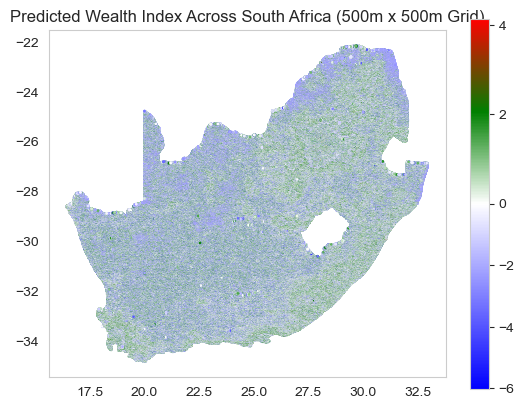

In [62]:
# Plot the predicted wealth index using the custom colormap and normalization
grid_gdf.plot(column='predicted_wealth_index', cmap=cmap, norm=norm, legend=True, markersize=1)
plt.title('Predicted Wealth Index Across South Africa (500m x 500m Grid)')
plt.show()

In [63]:
# Load the GeoJSON file
geojson_path = "D:/Extended Research Project/3. Project Kick Off (03_06_2024)/areas.geojson"
gdf = gpd.read_file(geojson_path)

# Filtering the data for iso3 == "ZAF" and area_level == 1 to get province
province_gdf = gdf[(gdf['iso3'] == 'ZAF') & (gdf['area_level'] == 1)]

# Saving the filtered data as a Shapefile
output_shapefile_path = 'D:/Extended Research Project/3. Project Kick Off (03_06_2024)/zaf_provinces.shp'
province_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')

# Output the path to the saved shapefile
output_shapefile_path

C:\Users\Raisina Chowdhury\AppData\Local\Temp\ipykernel_3836\1479858592.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  province_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'parent_area_id' to 'parent_are'
  ogr_write(
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'area_level_label' to 'area_lev_1'
  ogr_write(
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'spectrum_region_code' to 'spectrum_r'
  ogr_write(
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'area_sort_order' to 'area_sort_'
  ogr_write(


'D:/Extended Research Project/3. Project Kick Off (03_06_2024)/zaf_provinces.shp'

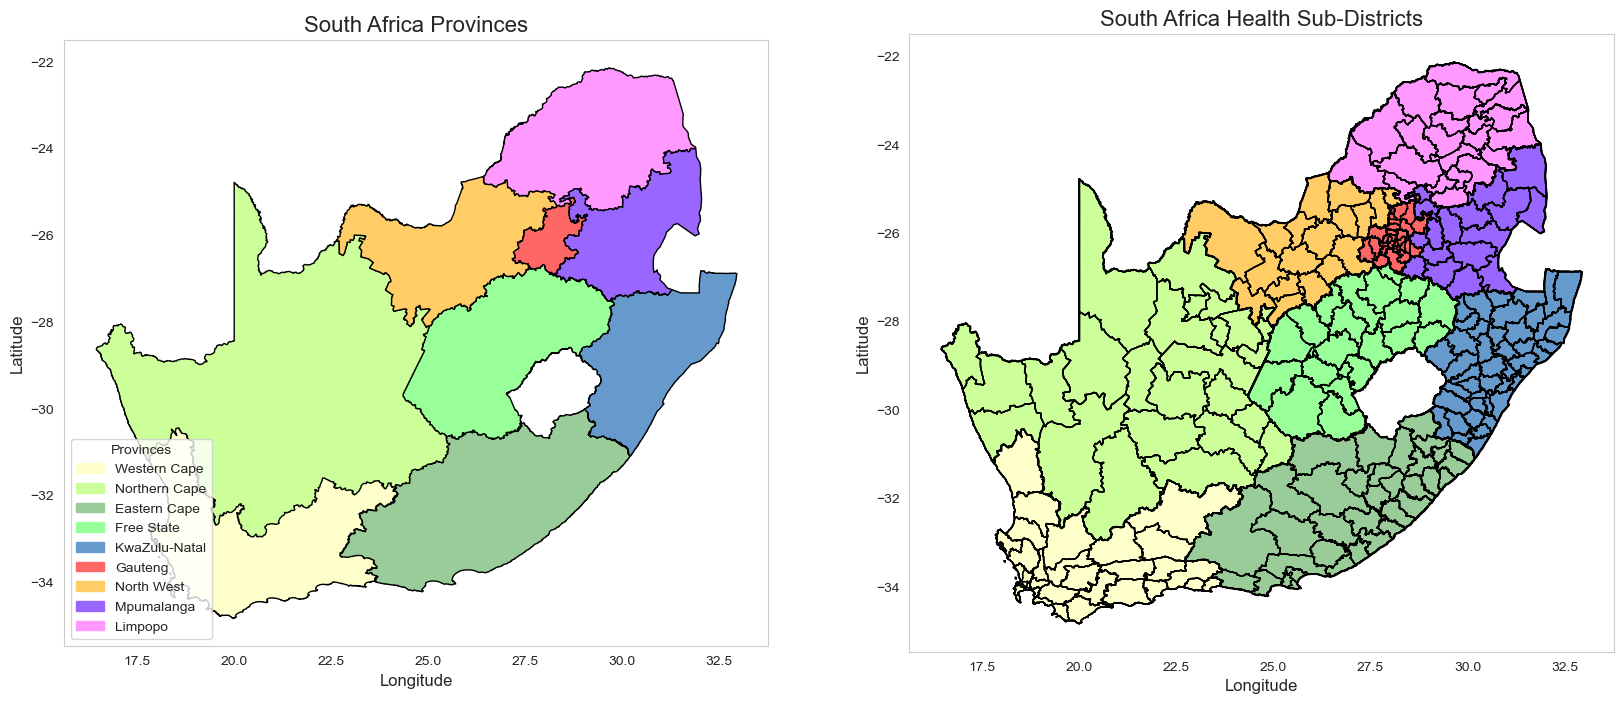

In [65]:
shapefile_gdf = gpd.read_file(shape_file) #health sub-district shapefile
#consistent colour
color_mapping = {
    'Western Cape': '#FFFFCC',
    'Northern Cape': '#CCFF99',
    'Eastern Cape': '#99CC99',
    'Free State': '#99FF99',
    'KwaZulu-Natal': '#6699CC',
    'Gauteng': '#FF6666',
    'North West': '#FFCC66',
    'Mpumalanga': '#9966FF',
    'Limpopo': '#FF99FF'
}

# Plot province and health sub-district shapefiles side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the province boundaries with the corresponding colors on the first subplot
for province in province_gdf.itertuples():
    color = color_mapping.get(province.area_name, '#FFFFFF')  # Default to white if not found
    province_gdf[province_gdf['area_name'] == province.area_name].plot(ax=ax1, color=color, edgecolor='black')

# Add the legend for provinces on the first map
handles = [plt.Rectangle((0,0),1,1, color=color_mapping[name]) for name in color_mapping]
ax1.legend(handles, color_mapping.keys(), title="Provinces", loc='lower left', fontsize=10)

# Plot the provinces with the same colors on the second subplot
for province in province_gdf.itertuples():
    color = color_mapping.get(province.area_name, '#FFFFFF')  # Default to white if not found
    shapefile_gdf[shapefile_gdf['area_name'] == province.area_name].plot(ax=ax2, color=color, edgecolor='black')

# Plot the inner boundaries explicitly on top of the filled provinces
shapefile_gdf.boundary.plot(ax=ax2, edgecolor='black', linewidth=1)  # Adjust linewidth as needed

# Set titles and labels for the plots
ax1.set_title('South Africa Provinces', fontsize=16)
ax2.set_title('South Africa Health Sub-Districts', fontsize=16)
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax2.set_xlabel('Longitude', fontsize=12)
ax2.set_ylabel('Latitude', fontsize=12)

# show the plots
plt.show()

In [66]:
# loading the province shapefile
provinces_gdf = gpd.read_file('D:/Extended Research Project/3. Project Kick Off (03_06_2024)/zaf_provinces.shp')

#same crs
grid_gdf = grid_gdf.to_crs(provinces_gdf.crs)

# Perform a spatial join to assign each grid point to a province

grid_with_province = gpd.sjoin(grid_gdf, provinces_gdf, how="inner", predicate="intersects")

# Group by province index and average predicted wealth index is calculated
province_wealth_index = grid_with_province.groupby(grid_with_province.index_right)['predicted_wealth_index'].mean().reset_index()

# Renaming columns
province_wealth_index.columns = ['province_index', 'average_predicted_wealth_index']

# joining the province wealh index with province geo data frame
provinces_gdf = provinces_gdf.merge(province_wealth_index, left_index=True, right_on='province_index')



#Shapefile containts the province geodata frame along with the average predicted wealth index of the provinces
output_shapefile_path = 'D:/Extended Research Project/3. Project Kick Off (03_06_2024)/province_wealth_index.shp'
provinces_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')

# Output the path to the saved shapefile
output_shapefile_path

C:\Users\Raisina Chowdhury\AppData\Local\Temp\ipykernel_3836\1062503224.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  provinces_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'province_index' to 'province_i'
  ogr_write(
C:\Users\Raisina Chowdhury\anaconda3\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'average_predicted_wealth_index' to 'average_pr'
  ogr_write(


'D:/Extended Research Project/3. Project Kick Off (03_06_2024)/province_wealth_index.shp'

C:\Users\Raisina Chowdhury\AppData\Local\Temp\ipykernel_3836\3207345366.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  provinces_gdf['centroid'] = provinces_gdf.geometry.centroid


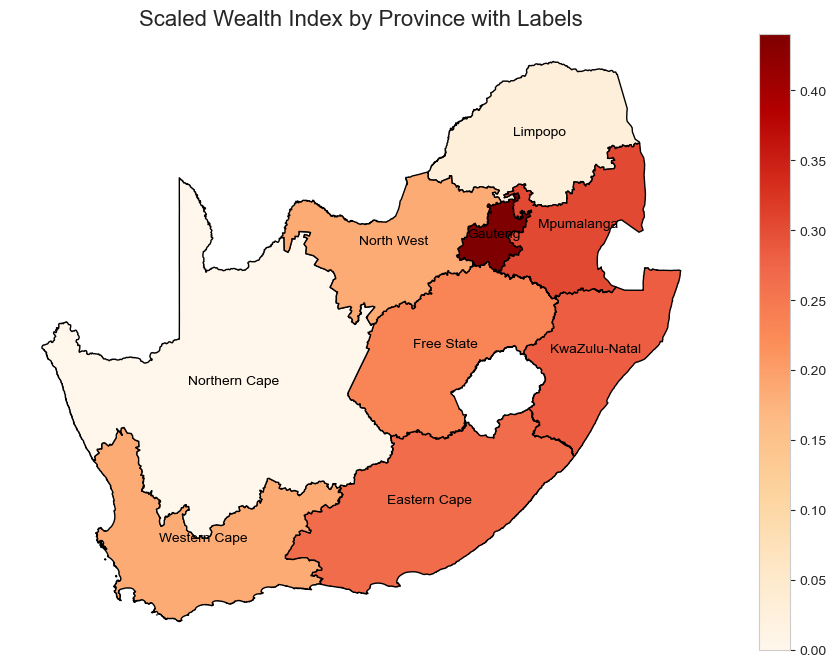

In [67]:
# Loading shapefile that was saved in the last cell
provinces_gdf = gpd.read_file('D:/Extended Research Project/3. Project Kick Off (03_06_2024)/province_wealth_index.shp')

# Rescaling for better interpretation
min_value = provinces_gdf['average_pr'].min()
provinces_gdf['scaled_wealth_index'] = provinces_gdf['average_pr'] - min_value

# Calculating the centroids of the provinces for labeling
provinces_gdf['centroid'] = provinces_gdf.geometry.centroid

#figure
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plotting using a colourmap
provinces_gdf.plot(column='scaled_wealth_index', 
                   ax=ax, 
                   legend=True,  
                   cmap='OrRd',  
                   edgecolor='black')  

# labeling the provinces at the center
for idx, row in provinces_gdf.iterrows():
    plt.text(s=row['area_name'],  
             x=row['centroid'].x, 
             y=row['centroid'].y, 
             horizontalalignment='center', 
             fontsize=10, 
             color='black')

# title labels and removing axis
plt.title('Scaled Wealth Index by Province with Labels', fontsize=16)
plt.axis('off')  

# Displaying the figure
plt.show()

<Figure size 1000x800 with 0 Axes>

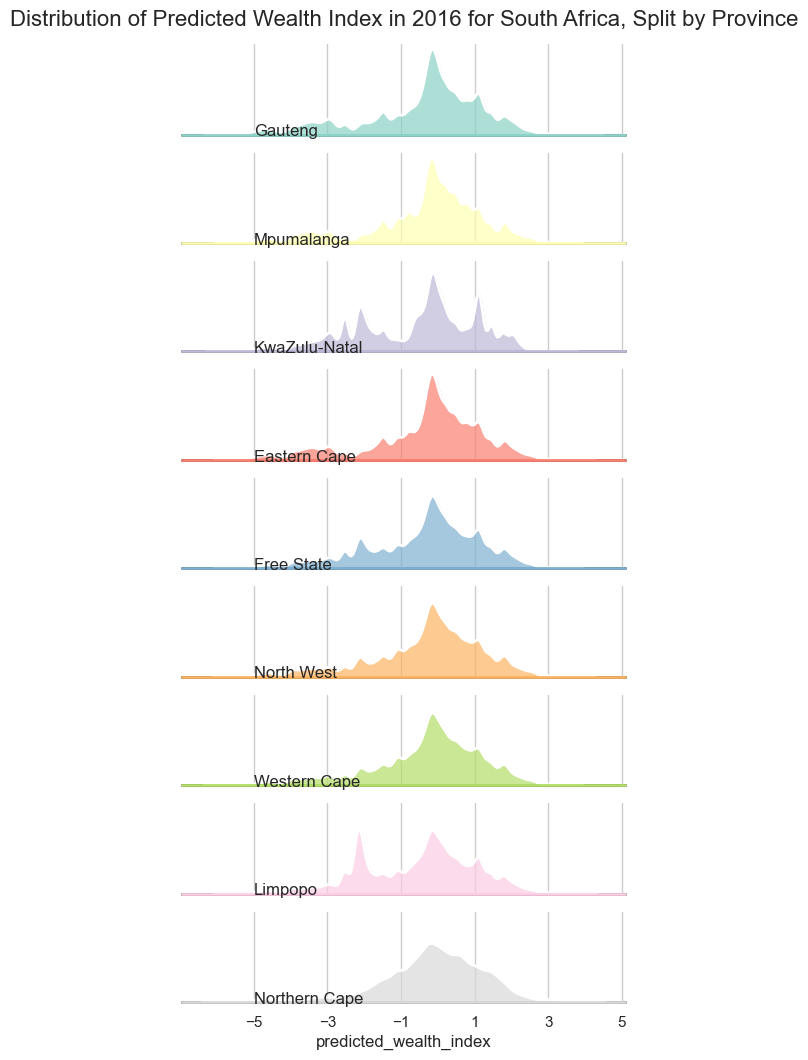

In [68]:

#columns selected
data = grid_with_province[['area_name', 'predicted_wealth_index']]

# matplotlib figure
plt.figure(figsize=(10, 8))

# Create the ridge plot using seaborn
sns.set(style="whitegrid")

#Facet grid allows multiple subplots, the rows correspond to the area names
g = sns.FacetGrid(data, row="area_name", hue="area_name", aspect=4, height=1.2, palette="Set3")
#KDE plot
g.map(sns.kdeplot, "predicted_wealth_index", fill=True, alpha=0.6)
g.map(sns.kdeplot, "predicted_wealth_index", color="w", lw=2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Adjust the subplots
g.fig.subplots_adjust(hspace=-0.5)

# titles and labels
g.set_titles("")
g.set(yticks=[])
g.set_xlabels("Wealth Index")
g.despine(bottom=True, left=True)

# Arranging the plots in descending order
means = data.groupby("area_name")["predicted_wealth_index"].mean().sort_values(ascending=False).index
g.fig.suptitle("Distribution of Predicted Wealth Index in 2016 for South Africa, Split by Province", fontsize=16)
g = g.set_titles(row_template="{row_name}")
g = g.set_axis_labels("Wealth Index", "")
g = g.set(yticks=[], ylabel="")
g = g.set_titles(col_template="", row_template="")
g = g.set(xticks=[-5, -3, -1, 1, 3, 5])
g = g.map(plt.axhline, y=0, lw=2, clip_on=False, color="k", zorder=0)
g = g.map_dataframe(sns.kdeplot, "predicted_wealth_index", fill=True)

# Rotate the province names to better fit the plot
for ax, name in zip(g.axes.flat, means):
    ax.text(-5, 0.02, name, fontsize=12, ha="left", va="center", rotation=0)

# Show the plot
plt.show()